**Case study: Bulk Deconvolution of synthetic bulk RNA samples with a human embryonic single-cell
reference profile**

This notebook is intended to illustrate a bulk deconvolution pipeline using AutoGeneS.
Here, signle-cell data set of human embryonic stem cells (Chu et al. 2016) is used as reference data for signature learning. 
The synthetic bulk RNA samples were generated by summing the sorted bulk RNA-seq read counts of the same tissue.

The deconvolution results are finally validated using the right proportions used for generating synthetic bulks.

The notebook takes approximately 8 minutes to run on a single core with sufficient RAM. 

# Loading the libraries

In [1]:
%config InlineBackend.figure_formats = ['retina']  # increase resolution on retina screens
import numpy as np
import scanpy as sc
import scipy as sci
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import autogenes as ag

from sklearn.svm import NuSVR
import pickle

/home/icb/hananeh.aliee/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def normalize_proportions(data,copy):
    if copy==True:
        data_copy = data.copy()
    else:
        data_copy = data
    data_copy[data_copy < 0] = 0
    for raw in data_copy.index:
        sum = data_copy.loc[raw].sum()
        data_copy.loc[raw] = np.divide(data_copy.loc[raw],sum)
    return data_copy

# Reading in the inputs

The Chu et al. data set was retrieved from the Gene Expression Omnibus (GEO) via the ID GSE75748. 
The following code expects to read the single cell data from folder "data" and bulk RNA samples and their proportions from folder "bulks".

The results are reproducible on a single machine but can slightly be different depending on  numpy and python versions. The current results are generated using the following packages:
* autogenes        1.0
* cachetools        4.0.0
* deap        1.3.1
* dill        0.3.1.1
* matplotlib        3.1.2
* numpy        1.16.4
* pandas        0.24.2
* scanpy        1.4.4.post1
* scipy        1.3.0
* seaborn        0.9.0
* Python 3.6.4 :: Anaconda, Inc.

In [3]:
#read single-cell data
file = './data/GSE75748_sc_cell_type_ec.csv'
adata = sc.read(file, cache=True).transpose()
adata

AnnData object with n_obs × n_vars = 1018 × 19097

In [4]:
#read 100 synthetic bulks generated by summing single cells
#the bulks are normalized to counts_per_cell_after=1e4
#proportions are only required for validation
path = './bulks/'
data_bulk_raw = pd.read_csv(path+'bulks.csv',delimiter='\t', index_col=0)
proportions = pd.read_csv(path + "proportions.csv", sep='\t', index_col=0)

In [5]:
adata.obs['cells'] = [x.split('_', 1)[0] for x in adata.obs_names]

In [6]:
def sub_sampling(adata,frac):
    clusters = list(set(adata.obs['cells']))
    cells = []
    for cluster in clusters:
        cell = adata[adata.obs['cells']==cluster].obs.sample(frac = frac).index
        cells.extend(cell)
    return adata[cells]

In [7]:
import random
def drop_out(adata,frac):
    adata_copy = adata.copy()
    size = adata_copy.X.shape[0]*adata_copy.X.shape[1]
    #random.seed(0)
    drops = random.sample(range(0, size), int(frac*size))
    print(len(drops))
    lin_adata = adata_copy.X.reshape(-1)
    lin_adata[drops] = 0
    adata_copy.X = lin_adata.reshape(adata_copy.X.shape[0],adata_copy.X.shape[1])
    return adata_copy

In [8]:
#adata_filter = adata[:,adata_log.var[adata_log.var['highly_variable']==True].index].copy()

In [9]:
rate = 0.0
adata_sample = drop_out(adata,rate)

0


In [12]:
#adata_sample = sub_sampling(adata,0.8)

# Preprocessing single-cell data

In [13]:
#normalizing and selecting 4000 hihgly variable genes for optimization
#we use log normalized data for selecting hihgly variable genes and visualization
adata_norm = sc.pp.normalize_per_cell(adata_sample, counts_per_cell_after=1e4, copy=True) 
adata_log = sc.pp.log1p(adata_norm, copy=True) 

In [14]:
adata_log

AnnData object with n_obs × n_vars = 1018 × 19097
    obs: 'cells', 'n_counts'
    uns: 'log1p'

In [15]:
sc.tl.rank_genes_groups(adata_log, groupby='cells', key_added='rank_cells',n_genes=3000)
mg = []
clusters = set(adata_log.obs['cells'])
markers = pd.DataFrame(columns = clusters)
list_mg = []
for clust in clusters:
    mg=adata_log.uns['rank_cells']['names'][clust][:1000]
    list_mg.extend(mg)
    markers.loc[:,clust] = mg

... storing 'cells' as categorical


In [16]:
len(set(list_mg))

5379

In [17]:
#sc.pp.highly_variable_genes(adata_log, flavor='cell_ranger', n_top_genes=4000)

In [18]:
adata_log = adata_log[:,~adata_log.var_names.isin(list(set(list_mg)))]

In [19]:
sc.pp.highly_variable_genes(adata_log, flavor='cell_ranger', n_top_genes=5000)
adata_log = adata_log[:, adata_log.var[adata_log.var['highly_variable']==False].index]#[:,~adata_log.var_names.isin(list(set(list_mg)))]
print(adata_log)
sc.pp.highly_variable_genes(adata_log, flavor='cell_ranger', n_top_genes=1000)


Trying to set attribute `.var` of view, copying.


View of AnnData object with n_obs × n_vars = 1018 × 8719
    obs: 'cells', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'rank_cells'


Trying to set attribute `.var` of view, copying.


In [20]:
#adata_log = adata_log[:,adata_log.var[adata_log.var['highly_variable']==True].index].copy()
#adata_norm = adata_norm[:,adata_log.var[adata_log.var['highly_variable']==True].index].copy()

In [21]:
adata_proc = adata_norm[:, adata_log.var[adata_log.var['highly_variable']==True].index].copy()
adata_proc

AnnData object with n_obs × n_vars = 1018 × 1000
    obs: 'cells', 'n_counts'

In [22]:
pd.DataFrame(adata_proc.X.T, index= adata_proc.var_names, columns=adata_proc.obs['cells']).to_csv('cibersort_'+str(rate)+'.txt',sep='\t')

In [23]:
adata_log = adata_log[:,adata_proc.var_names]

In [24]:
sc.tl.rank_genes_groups(adata_log, groupby='cells', key_added='rank_cells',n_genes=600)
mg = []
clusters = set(adata_log.obs['cells'])
markers = pd.DataFrame(columns = clusters)
list_mg = []
for clust in clusters:
    mg=adata_log.uns['rank_cells']['names'][clust][:35]
    list_mg.extend(mg)
    markers.loc[:,clust] = mg

Trying to set attribute `.uns` of view, copying.


In [25]:
len(np.intersect1d(adata_proc.var_names,list(set(list_mg))))

214

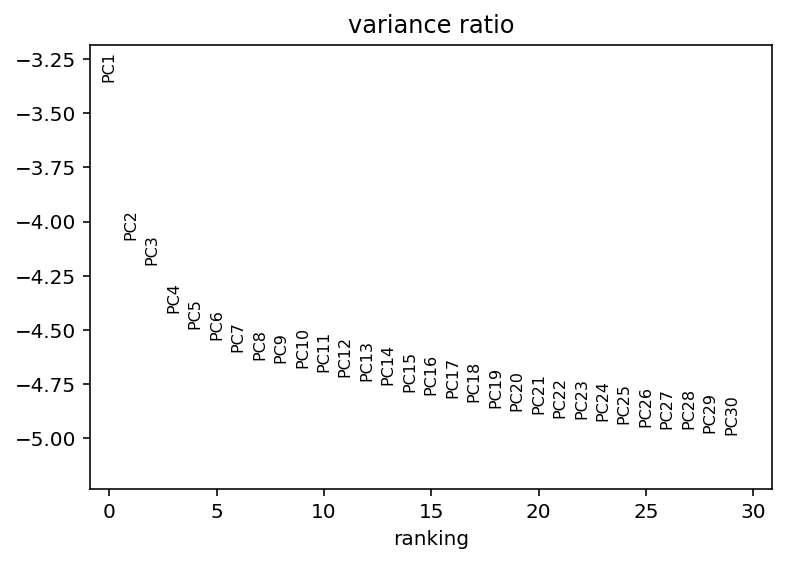

In [26]:
#adata_log = adata_log[:,centroids_sc_mg.index]
sc.pp.pca(adata_log, n_comps=30, use_highly_variable=False, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_log, log=True)

In [27]:
adata_log.obs['cells'] = [x.split('_', 1)[0] for x in adata_log.obs_names]

In [28]:
sc.set_figure_params(dpi=100, dpi_save=300, vector_friendly=True)
params = {'legend.fontsize': 8,
          'figure.figsize': (3, 3),
         'axes.labelsize':8,
         'axes.titlesize':8,
         'xtick.labelsize':8,
         'ytick.labelsize':8}
plt.rcParams.update(params)

... storing 'cells' as categorical


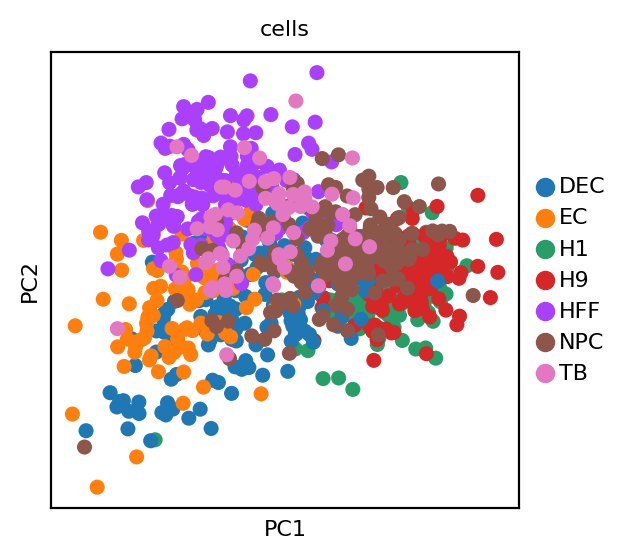

In [29]:
adata_log.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
sc.pl.pca_scatter(adata_log, color='cells')

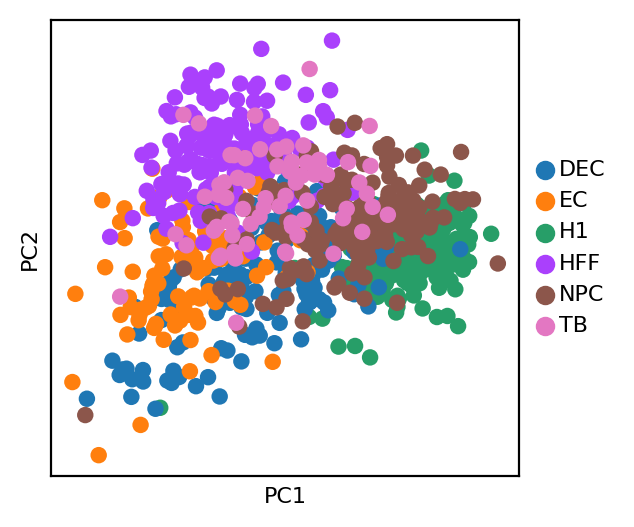

In [30]:
#remove H9 because of high correlation with H1
adata_log = adata_log[adata_log.obs[adata_log.obs['cells'] != 'H9'].index]
sc.pl.pca_scatter(adata_log, color='cells',title='',save='synthetic.pdf')

In [31]:
#filter cells in normalized data
adata_proc = adata_proc[adata_proc.obs[adata_proc.obs['cells'] != 'H9'].index]

In [32]:
adata_proc

View of AnnData object with n_obs × n_vars = 856 × 1000
    obs: 'cells', 'n_counts'

In [33]:
#calculating the centroids of cell types
clusters = np.array(['DEC', 'EC', 'H1', 'HFF', 'NPC', 'TB'])
sc_mean = pd.DataFrame(index=adata_proc.var_names,columns=clusters)
for cluster in clusters:
    cells = [x for x in adata_proc.obs_names if adata_proc.obs.loc[x,'cells']==cluster]
    sc_part = adata_proc[cells,:].X.T
    sc_mean[cluster] = pd.DataFrame(np.mean(sc_part,axis=1),index=adata_proc.var_names)
    del(sc_part)
centroids_sc_hv = sc_mean
centroids_sc_hv.shape

(1000, 6)

In [34]:
sc_means = pd.DataFrame(data=adata_proc.X, columns=adata_proc.var_names)
sc_means['cell_types'] = pd.Series(data=adata_proc.obs['cells'].values,index=sc_means.index)
sc_means = sc_means.groupby('cell_types').mean()

In [35]:
pd.options.display.precision = 10

# AutoGeneS

### Optimization

In [36]:
import datetime
del ag
import autogenes as ag
print(datetime.datetime.now())
time0 = datetime.datetime.now()
test = ag.init(sc_means)
ag.optimize(ngen=10000,seed=0,nfeatures=200,mode='fixed',offspring_size=100)#,verbose=False)
print(datetime.datetime.now()-time0)

2020-07-31 02:13:30.943198
gen	nevals	pareto	correlation  	distance     
0  	100   	10    	12.72 - 14.07	21.73 - 34.96
1  	100   	10    	12.72 - 13.94	21.73 - 34.96
2  	100   	10    	12.72 - 13.86	21.22 - 34.96
3  	100   	10    	12.72 - 13.78	21.87 - 34.96
4  	100   	15    	12.72 - 13.78	22.26 - 34.96
5  	100   	18    	12.72 - 13.76	23.26 - 34.96
6  	100   	11    	12.72 - 13.76	22.14 - 34.96
7  	100   	12    	12.72 - 13.75	22.14 - 35.24
8  	100   	12    	12.72 - 13.75	23.2 - 35.24 
9  	100   	13    	12.72 - 13.75	23.2 - 35.24 
10 	100   	15    	12.72 - 13.75	23.2 - 35.24 
11 	100   	16    	12.72 - 13.75	23.2 - 35.24 
12 	100   	17    	12.72 - 13.63	23.29 - 35.24
13 	100   	17    	12.72 - 13.63	23.29 - 35.24
14 	100   	17    	12.72 - 13.63	23.29 - 35.24
15 	100   	17    	12.71 - 13.63	23.29 - 35.24
16 	100   	15    	12.71 - 13.63	23.29 - 35.24
17 	100   	15    	12.71 - 13.63	23.29 - 35.24
18 	100   	15    	12.71 - 13.63	23.29 - 35.24
19 	100   	13    	12.71 - 13.63	23.29 - 35.32
20 	100

181	100   	22    	12.11 - 13.4 	25.61 - 38.14
182	100   	23    	12.1 - 13.4  	25.61 - 38.14
183	100   	24    	12.1 - 13.4  	25.61 - 38.14
184	100   	23    	12.1 - 13.4  	25.62 - 38.14
185	100   	23    	12.1 - 13.4  	25.62 - 38.14
186	100   	24    	12.1 - 13.4  	25.62 - 38.14
187	100   	24    	12.1 - 13.4  	25.62 - 38.14
188	100   	24    	12.1 - 13.4  	25.62 - 38.14
189	100   	25    	12.1 - 13.4  	25.62 - 38.14
190	100   	24    	12.09 - 13.4 	25.93 - 38.14
191	100   	26    	12.09 - 13.42	25.93 - 38.27
192	100   	26    	12.08 - 13.42	25.96 - 38.27
193	100   	26    	12.08 - 13.42	25.96 - 38.27
194	100   	27    	12.08 - 13.42	25.96 - 38.27
195	100   	28    	12.08 - 13.42	25.96 - 38.27
196	100   	28    	12.08 - 13.42	25.96 - 38.27
197	100   	27    	12.08 - 13.42	25.96 - 38.27
198	100   	27    	12.08 - 13.42	25.96 - 38.27
199	100   	27    	12.08 - 13.42	25.97 - 38.27
200	100   	26    	12.08 - 13.42	25.03 - 38.27
201	100   	26    	12.08 - 13.42	25.03 - 38.33
202	100   	23    	12.08 - 13.42	25

366	100   	33    	11.48 - 13.47	24.96 - 40.5 
367	100   	34    	11.48 - 13.47	24.96 - 40.5 
368	100   	33    	11.48 - 13.47	24.96 - 40.5 
369	100   	35    	11.48 - 13.46	24.96 - 40.51
370	100   	35    	11.48 - 13.46	24.96 - 40.51
371	100   	33    	11.48 - 13.46	24.96 - 40.51
372	100   	33    	11.48 - 13.46	24.96 - 40.51
373	100   	32    	11.48 - 13.46	24.96 - 40.51
374	100   	29    	11.48 - 13.46	24.96 - 40.51
375	100   	29    	11.48 - 13.46	24.96 - 40.51
376	100   	31    	11.48 - 13.46	24.96 - 40.86
377	100   	31    	11.48 - 13.46	24.96 - 40.86
378	100   	32    	11.48 - 13.46	24.96 - 40.86
379	100   	30    	11.48 - 13.46	24.96 - 40.86
380	100   	30    	11.48 - 13.46	24.96 - 40.86
381	100   	33    	11.48 - 13.46	24.96 - 40.86
382	100   	33    	11.48 - 13.46	24.96 - 40.86
383	100   	35    	11.48 - 13.45	24.96 - 40.94
384	100   	36    	11.48 - 13.45	24.96 - 40.94
385	100   	36    	11.48 - 13.45	24.96 - 40.94
386	100   	33    	11.48 - 13.45	24.96 - 40.94
387	100   	33    	11.48 - 13.45	24

548	100   	48    	10.95 - 13.51	24.18 - 42.43
549	100   	48    	10.95 - 13.51	24.18 - 42.43
550	100   	48    	10.95 - 13.51	24.18 - 42.43
551	100   	48    	10.95 - 13.51	24.18 - 42.43
552	100   	49    	10.95 - 13.51	24.18 - 42.43
553	100   	49    	10.95 - 13.51	24.18 - 42.44
554	100   	51    	10.95 - 13.51	24.18 - 42.44
555	100   	48    	10.95 - 13.51	24.18 - 42.44
556	100   	49    	10.95 - 13.51	24.18 - 42.44
557	100   	47    	10.95 - 13.51	24.18 - 42.44
558	100   	47    	10.95 - 13.51	24.18 - 42.44
559	100   	47    	10.95 - 13.51	24.18 - 42.44
560	100   	47    	10.95 - 13.51	24.18 - 42.44
561	100   	47    	10.95 - 13.51	24.18 - 42.44
562	100   	48    	10.95 - 13.51	24.18 - 42.44
563	100   	50    	10.95 - 13.51	24.18 - 42.44
564	100   	51    	10.95 - 13.51	24.18 - 42.44
565	100   	51    	10.95 - 13.51	24.18 - 42.44
566	100   	51    	10.95 - 13.51	24.18 - 42.44
567	100   	51    	10.95 - 13.51	24.18 - 42.44
568	100   	48    	10.95 - 13.51	24.18 - 42.44
569	100   	49    	10.95 - 13.51	24

727	100   	58    	10.75 - 13.41	24.59 - 42.77
728	100   	58    	10.75 - 13.41	24.59 - 42.77
729	100   	58    	10.75 - 13.41	24.59 - 42.77
730	100   	58    	10.75 - 13.41	24.59 - 42.77
731	100   	55    	10.75 - 13.41	24.59 - 42.77
732	100   	57    	10.75 - 13.41	24.59 - 42.77
733	100   	54    	10.75 - 13.41	24.59 - 42.77
734	100   	56    	10.75 - 13.41	24.59 - 42.77
735	100   	55    	10.75 - 13.41	24.59 - 42.77
736	100   	56    	10.75 - 13.41	24.59 - 42.77
737	100   	57    	10.75 - 13.41	24.59 - 42.77
738	100   	58    	10.75 - 13.41	24.59 - 42.77
739	100   	57    	10.75 - 13.41	24.59 - 42.77
740	100   	59    	10.75 - 13.41	24.59 - 42.77
741	100   	59    	10.75 - 13.41	24.59 - 42.77
742	100   	59    	10.75 - 13.41	24.59 - 42.77
743	100   	59    	10.75 - 13.41	24.59 - 42.8 
744	100   	61    	10.71 - 13.41	24.53 - 42.8 
745	100   	61    	10.71 - 13.41	24.53 - 42.8 
746	100   	61    	10.71 - 13.41	24.53 - 42.8 
747	100   	60    	10.71 - 13.41	24.53 - 42.8 
748	100   	62    	10.71 - 13.41	24

907	100   	60    	10.48 - 13.36	24.45 - 43.9 
908	100   	57    	10.48 - 13.36	24.45 - 43.9 
909	100   	57    	10.48 - 13.36	24.45 - 43.9 
910	100   	58    	10.48 - 13.36	24.45 - 43.9 
911	100   	58    	10.48 - 13.36	24.45 - 43.9 
912	100   	55    	10.48 - 13.36	24.45 - 43.9 
913	100   	54    	10.48 - 13.36	24.45 - 43.9 
914	100   	54    	10.48 - 13.36	24.45 - 43.9 
915	100   	55    	10.48 - 13.36	24.45 - 43.9 
916	100   	53    	10.48 - 13.36	24.45 - 43.9 
917	100   	53    	10.48 - 13.36	24.45 - 43.9 
918	100   	53    	10.48 - 13.36	24.46 - 43.9 
919	100   	54    	10.48 - 13.36	24.46 - 43.9 
920	100   	54    	10.48 - 13.36	24.46 - 43.9 
921	100   	54    	10.48 - 13.36	24.46 - 43.9 
922	100   	55    	10.48 - 13.36	24.46 - 43.9 
923	100   	55    	10.48 - 13.36	24.46 - 43.9 
924	100   	55    	10.48 - 13.36	24.46 - 43.96
925	100   	56    	10.48 - 13.36	24.46 - 43.96
926	100   	56    	10.48 - 13.36	24.46 - 43.96
927	100   	55    	10.48 - 13.36	24.46 - 43.96
928	100   	52    	10.48 - 13.36	24

1088	100   	60    	10.39 - 13.36	25.31 - 44.51
1089	100   	59    	10.39 - 13.36	25.31 - 44.51
1090	100   	60    	10.39 - 13.36	25.31 - 44.51
1091	100   	60    	10.39 - 13.36	25.31 - 44.51
1092	100   	60    	10.39 - 13.33	25.31 - 44.85
1093	100   	62    	10.39 - 13.33	25.31 - 44.85
1094	100   	63    	10.39 - 13.33	25.31 - 44.85
1095	100   	66    	10.39 - 13.33	25.31 - 44.85
1096	100   	69    	10.39 - 13.33	25.31 - 44.85
1097	100   	69    	10.39 - 13.33	25.31 - 44.85
1098	100   	68    	10.39 - 13.33	25.31 - 44.85
1099	100   	68    	10.39 - 13.33	25.31 - 44.85
1100	100   	67    	10.39 - 13.33	25.31 - 44.85
1101	100   	65    	10.39 - 13.33	25.31 - 44.85
1102	100   	66    	10.39 - 13.33	25.31 - 44.87
1103	100   	66    	10.39 - 13.33	25.31 - 44.87
1104	100   	68    	10.39 - 13.33	25.31 - 44.87
1105	100   	68    	10.39 - 13.33	25.31 - 44.87
1106	100   	70    	10.39 - 13.33	25.31 - 44.87
1107	100   	71    	10.39 - 13.33	25.31 - 44.87
1108	100   	73    	10.39 - 13.33	25.31 - 44.87
1109	100   	7

1263	100   	62    	10.33 - 13.36	25.09 - 46.22
1264	100   	62    	10.33 - 13.36	25.09 - 46.22
1265	100   	61    	10.33 - 13.36	25.09 - 46.22
1266	100   	61    	10.33 - 13.36	25.09 - 46.22
1267	100   	59    	10.33 - 13.36	25.09 - 46.22
1268	100   	56    	10.33 - 13.36	25.09 - 46.22
1269	100   	56    	10.33 - 13.36	25.09 - 46.22
1270	100   	56    	10.33 - 13.36	25.09 - 46.22
1271	100   	56    	10.33 - 13.36	25.09 - 46.22
1272	100   	56    	10.32 - 13.36	25.1 - 46.22 
1273	100   	56    	10.32 - 13.36	25.1 - 46.22 
1274	100   	56    	10.32 - 13.36	25.1 - 46.22 
1275	100   	57    	10.32 - 13.36	25.1 - 46.22 
1276	100   	59    	10.32 - 13.36	25.1 - 46.22 
1277	100   	59    	10.32 - 13.36	25.1 - 46.22 
1278	100   	58    	10.32 - 13.36	25.1 - 46.22 
1279	100   	58    	10.32 - 13.36	25.1 - 46.22 
1280	100   	59    	10.32 - 13.36	25.1 - 46.22 
1281	100   	59    	10.32 - 13.36	25.1 - 46.31 
1282	100   	61    	10.32 - 13.36	25.1 - 46.31 
1283	100   	59    	10.32 - 13.36	25.1 - 46.31 
1284	100   	5

1438	100   	63    	10.21 - 13.41	24.61 - 46.64
1439	100   	63    	10.21 - 13.41	24.61 - 46.64
1440	100   	67    	10.21 - 13.41	24.61 - 46.64
1441	100   	68    	10.21 - 13.41	24.61 - 46.64
1442	100   	68    	10.21 - 13.4 	24.61 - 46.71
1443	100   	70    	10.21 - 13.4 	24.61 - 46.71
1444	100   	70    	10.21 - 13.4 	24.61 - 46.71
1445	100   	70    	10.21 - 13.4 	24.61 - 46.71
1446	100   	69    	10.21 - 13.4 	24.61 - 46.71
1447	100   	69    	10.21 - 13.4 	24.61 - 46.71
1448	100   	71    	10.21 - 13.4 	24.61 - 46.71
1449	100   	70    	10.21 - 13.4 	24.61 - 46.71
1450	100   	70    	10.21 - 13.4 	24.61 - 46.71
1451	100   	69    	10.21 - 13.43	24.61 - 46.92
1452	100   	69    	10.21 - 13.43	24.61 - 46.92
1453	100   	70    	10.21 - 13.43	24.61 - 46.92
1454	100   	70    	10.21 - 13.43	24.61 - 46.92
1455	100   	70    	10.21 - 13.43	24.61 - 46.92
1456	100   	70    	10.21 - 13.43	24.61 - 46.92
1457	100   	72    	10.21 - 13.43	24.61 - 46.92
1458	100   	73    	10.21 - 13.43	24.61 - 46.92
1459	100   	7

1613	100   	82    	10.16 - 13.41	25.01 - 47.87
1614	100   	81    	10.16 - 13.41	25.01 - 47.87
1615	100   	83    	10.16 - 13.41	25.01 - 47.87
1616	100   	84    	10.16 - 13.41	25.01 - 47.87
1617	100   	83    	10.16 - 13.41	25.01 - 47.87
1618	100   	83    	10.16 - 13.41	25.01 - 47.87
1619	100   	84    	10.16 - 13.41	25.01 - 47.87
1620	100   	84    	10.16 - 13.41	25.01 - 47.87
1621	100   	85    	10.16 - 13.41	25.01 - 47.87
1622	100   	88    	10.16 - 13.41	25.01 - 47.92
1623	100   	87    	10.16 - 13.41	25.01 - 47.92
1624	100   	88    	10.16 - 13.41	25.01 - 47.92
1625	100   	86    	10.14 - 13.41	25.07 - 47.92
1626	100   	85    	10.14 - 13.41	25.07 - 47.92
1627	100   	86    	10.14 - 13.41	25.07 - 47.92
1628	100   	86    	10.14 - 13.41	25.07 - 47.92
1629	100   	88    	10.14 - 13.41	25.07 - 47.92
1630	100   	91    	10.14 - 13.41	25.07 - 47.92
1631	100   	91    	10.14 - 13.41	25.07 - 47.92
1632	100   	91    	10.14 - 13.41	25.07 - 47.92
1633	100   	90    	10.14 - 13.41	25.07 - 47.92
1634	100   	8

1791	100   	78    	10.06 - 13.41	25.12 - 47.92
1792	100   	78    	10.06 - 13.41	25.12 - 47.92
1793	100   	77    	10.06 - 13.41	25.12 - 47.92
1794	100   	77    	10.06 - 13.41	25.12 - 47.92
1795	100   	77    	10.06 - 13.41	25.12 - 47.92
1796	100   	77    	10.06 - 13.41	25.12 - 47.92
1797	100   	78    	10.06 - 13.41	25.12 - 47.92
1798	100   	79    	10.06 - 13.41	25.12 - 47.92
1799	100   	80    	10.06 - 13.41	25.12 - 47.92
1800	100   	77    	10.05 - 13.41	25.14 - 47.92
1801	100   	75    	10.05 - 13.41	25.14 - 47.92
1802	100   	78    	10.05 - 13.41	25.14 - 47.92
1803	100   	78    	10.05 - 13.41	25.14 - 47.92
1804	100   	78    	10.05 - 13.41	25.14 - 47.92
1805	100   	79    	10.05 - 13.41	25.14 - 47.92
1806	100   	79    	10.05 - 13.41	25.14 - 47.92
1807	100   	78    	10.05 - 13.41	25.14 - 47.92
1808	100   	78    	10.05 - 13.41	25.14 - 47.92
1809	100   	81    	10.05 - 13.41	25.14 - 47.92
1810	100   	81    	10.05 - 13.41	25.14 - 47.92
1811	100   	79    	10.05 - 13.41	25.14 - 47.92
1812	100   	7

1966	100   	65    	10.01 - 13.37	25.33 - 47.98
1967	100   	65    	10.01 - 13.37	25.33 - 47.98
1968	100   	66    	10.01 - 13.37	25.33 - 47.98
1969	100   	62    	10.01 - 13.37	25.33 - 47.98
1970	100   	63    	10.01 - 13.37	25.33 - 47.98
1971	100   	64    	10.01 - 13.37	25.33 - 47.98
1972	100   	64    	10.01 - 13.37	25.33 - 47.98
1973	100   	64    	10.01 - 13.37	25.33 - 47.98
1974	100   	65    	10.01 - 13.37	25.33 - 47.98
1975	100   	67    	10.01 - 13.37	25.33 - 47.98
1976	100   	69    	10.01 - 13.37	25.33 - 47.98
1977	100   	69    	9.97 - 13.37 	25.45 - 47.98
1978	100   	69    	9.97 - 13.37 	25.45 - 47.98
1979	100   	68    	9.97 - 13.37 	25.45 - 47.98
1980	100   	69    	9.97 - 13.37 	25.45 - 47.98
1981	100   	71    	9.97 - 13.37 	25.45 - 47.98
1982	100   	71    	9.96 - 13.37 	25.55 - 47.98
1983	100   	69    	9.96 - 13.37 	25.55 - 47.98
1984	100   	70    	9.96 - 13.37 	25.55 - 47.98
1985	100   	71    	9.96 - 13.37 	25.55 - 47.98
1986	100   	71    	9.96 - 13.37 	25.55 - 47.98
1987	100   	7

2145	100   	81    	9.95 - 13.36 	25.67 - 48.03
2146	100   	83    	9.95 - 13.36 	25.67 - 48.03
2147	100   	83    	9.95 - 13.36 	25.67 - 48.03
2148	100   	84    	9.95 - 13.36 	25.67 - 48.03
2149	100   	83    	9.95 - 13.36 	25.67 - 48.03
2150	100   	83    	9.95 - 13.36 	25.67 - 48.03
2151	100   	84    	9.95 - 13.36 	25.67 - 48.03
2152	100   	85    	9.95 - 13.36 	25.67 - 48.03
2153	100   	83    	9.93 - 13.36 	25.73 - 48.03
2154	100   	81    	9.93 - 13.36 	25.73 - 48.03
2155	100   	83    	9.93 - 13.36 	25.73 - 48.03
2156	100   	82    	9.93 - 13.36 	25.73 - 48.03
2157	100   	81    	9.93 - 13.36 	25.73 - 48.03
2158	100   	80    	9.93 - 13.36 	25.73 - 48.03
2159	100   	80    	9.93 - 13.36 	25.73 - 48.03
2160	100   	78    	9.88 - 13.36 	25.5 - 48.03 
2161	100   	76    	9.88 - 13.36 	25.5 - 48.03 
2162	100   	76    	9.88 - 13.36 	25.5 - 48.03 
2163	100   	76    	9.88 - 13.36 	25.5 - 48.03 
2164	100   	77    	9.88 - 13.36 	25.5 - 48.03 
2165	100   	78    	9.88 - 13.36 	25.5 - 48.03 
2166	100   	7

2320	100   	88    	9.76 - 13.24 	25.76 - 48.32
2321	100   	89    	9.76 - 13.24 	25.76 - 48.32
2322	100   	88    	9.76 - 13.24 	25.76 - 48.32
2323	100   	89    	9.76 - 13.24 	25.76 - 48.32
2324	100   	88    	9.76 - 13.24 	25.76 - 48.32
2325	100   	89    	9.76 - 13.24 	25.76 - 48.32
2326	100   	91    	9.76 - 13.24 	25.76 - 48.32
2327	100   	90    	9.76 - 13.24 	25.76 - 48.32
2328	100   	91    	9.76 - 13.24 	25.76 - 48.32
2329	100   	91    	9.76 - 13.24 	25.76 - 48.32
2330	100   	92    	9.76 - 13.24 	25.76 - 48.32
2331	100   	92    	9.76 - 13.24 	25.76 - 48.32
2332	100   	90    	9.76 - 13.24 	25.76 - 48.32
2333	100   	90    	9.76 - 13.24 	25.76 - 48.32
2334	100   	92    	9.76 - 13.24 	25.76 - 48.32
2335	100   	92    	9.76 - 13.24 	25.76 - 48.32
2336	100   	93    	9.76 - 13.24 	25.76 - 48.32
2337	100   	94    	9.76 - 13.24 	25.76 - 48.32
2338	100   	94    	9.76 - 13.24 	25.76 - 48.32
2339	100   	94    	9.76 - 13.24 	25.76 - 48.32
2340	100   	92    	9.76 - 13.24 	25.76 - 48.32
2341	100   	9

2496	100   	106   	9.72 - 13.2  	25.87 - 48.51
2497	100   	106   	9.72 - 13.2  	25.87 - 48.51
2498	100   	106   	9.72 - 13.2  	25.87 - 48.51
2499	100   	105   	9.72 - 13.2  	25.87 - 48.51
2500	100   	107   	9.72 - 13.2  	25.87 - 48.51
2501	100   	108   	9.72 - 13.2  	25.87 - 48.51
2502	100   	108   	9.72 - 13.2  	25.87 - 48.51
2503	100   	109   	9.72 - 13.2  	25.87 - 48.51
2504	100   	109   	9.72 - 13.2  	25.87 - 48.51
2505	100   	111   	9.72 - 13.2  	25.87 - 48.51
2506	100   	109   	9.72 - 13.2  	25.87 - 48.51
2507	100   	109   	9.72 - 13.2  	25.87 - 48.51
2508	100   	109   	9.72 - 13.2  	25.87 - 48.51
2509	100   	109   	9.72 - 13.2  	25.87 - 48.51
2510	100   	111   	9.72 - 13.2  	25.87 - 48.51
2511	100   	111   	9.72 - 13.2  	25.87 - 48.51
2512	100   	107   	9.72 - 13.2  	25.87 - 48.51
2513	100   	107   	9.72 - 13.2  	25.87 - 48.51
2514	100   	106   	9.72 - 13.2  	25.87 - 48.51
2515	100   	106   	9.72 - 13.2  	25.87 - 48.51
2516	100   	106   	9.72 - 13.2  	25.87 - 48.51
2517	100   	1

2671	100   	89    	9.7 - 13.18  	25.92 - 48.58
2672	100   	90    	9.7 - 13.18  	25.92 - 48.58
2673	100   	91    	9.7 - 13.18  	25.92 - 48.58
2674	100   	91    	9.7 - 13.18  	25.92 - 48.58
2675	100   	88    	9.7 - 13.18  	25.92 - 48.58
2676	100   	88    	9.7 - 13.18  	25.92 - 48.58
2677	100   	88    	9.7 - 13.18  	25.92 - 48.58
2678	100   	89    	9.7 - 13.18  	25.92 - 48.58
2679	100   	89    	9.7 - 13.18  	25.92 - 48.58
2680	100   	89    	9.7 - 13.18  	25.92 - 48.58
2681	100   	87    	9.7 - 13.18  	25.92 - 48.58
2682	100   	83    	9.7 - 13.18  	25.92 - 48.58
2683	100   	84    	9.7 - 13.18  	25.92 - 48.58
2684	100   	84    	9.7 - 13.18  	25.92 - 48.58
2685	100   	87    	9.7 - 13.18  	25.92 - 48.59
2686	100   	87    	9.7 - 13.18  	25.92 - 48.59
2687	100   	88    	9.7 - 13.18  	25.92 - 48.59
2688	100   	88    	9.7 - 13.15  	25.92 - 49.06
2689	100   	88    	9.7 - 13.15  	25.92 - 49.06
2690	100   	87    	9.7 - 13.15  	25.92 - 49.06
2691	100   	88    	9.7 - 13.15  	25.92 - 49.06
2692	100   	8

2847	100   	105   	9.65 - 13.14 	25.59 - 49.14
2848	100   	106   	9.65 - 13.14 	25.59 - 49.14
2849	100   	107   	9.65 - 13.14 	25.59 - 49.14
2850	100   	107   	9.65 - 13.14 	25.59 - 49.14
2851	100   	107   	9.65 - 13.14 	25.59 - 49.14
2852	100   	108   	9.65 - 13.14 	25.59 - 49.14
2853	100   	108   	9.65 - 13.14 	25.59 - 49.14
2854	100   	108   	9.65 - 13.14 	25.59 - 49.14
2855	100   	109   	9.65 - 13.14 	25.59 - 49.14
2856	100   	108   	9.65 - 13.14 	25.59 - 49.14
2857	100   	111   	9.65 - 13.14 	25.59 - 49.14
2858	100   	110   	9.65 - 13.14 	25.59 - 49.14
2859	100   	110   	9.65 - 13.14 	25.59 - 49.14
2860	100   	111   	9.65 - 13.14 	25.59 - 49.14
2861	100   	112   	9.65 - 13.14 	25.59 - 49.14
2862	100   	112   	9.65 - 13.14 	25.59 - 49.14
2863	100   	112   	9.65 - 13.14 	25.59 - 49.14
2864	100   	111   	9.65 - 13.14 	25.59 - 49.14
2865	100   	112   	9.65 - 13.14 	25.59 - 49.14
2866	100   	113   	9.65 - 13.14 	25.59 - 49.14
2867	100   	113   	9.65 - 13.14 	25.59 - 49.14
2868	100   	1

3023	100   	97    	9.55 - 13.1  	25.34 - 49.41
3024	100   	97    	9.55 - 13.1  	25.34 - 49.41
3025	100   	97    	9.55 - 13.1  	25.34 - 49.41
3026	100   	98    	9.55 - 13.1  	25.34 - 49.41
3027	100   	99    	9.55 - 13.1  	25.34 - 49.41
3028	100   	99    	9.55 - 13.1  	25.34 - 49.41
3029	100   	97    	9.55 - 13.1  	25.34 - 49.41
3030	100   	95    	9.55 - 13.1  	25.34 - 49.41
3031	100   	90    	9.55 - 13.1  	25.34 - 49.41
3032	100   	91    	9.55 - 13.1  	25.34 - 49.41
3033	100   	92    	9.55 - 13.1  	25.34 - 49.41
3034	100   	93    	9.55 - 13.1  	25.34 - 49.41
3035	100   	94    	9.55 - 13.1  	25.34 - 49.41
3036	100   	93    	9.55 - 13.1  	25.34 - 49.41
3037	100   	94    	9.55 - 13.1  	25.34 - 49.41
3038	100   	91    	9.55 - 13.1  	25.34 - 49.41
3039	100   	88    	9.55 - 13.1  	25.34 - 49.41
3040	100   	88    	9.55 - 13.1  	25.34 - 49.41
3041	100   	88    	9.55 - 13.1  	25.34 - 49.41
3042	100   	88    	9.55 - 13.1  	25.34 - 49.41
3043	100   	88    	9.55 - 13.1  	25.34 - 49.41
3044	100   	8

3198	100   	102   	9.54 - 13.09 	25.36 - 49.47
3199	100   	102   	9.54 - 13.09 	25.36 - 49.47
3200	100   	101   	9.54 - 13.09 	25.36 - 49.47
3201	100   	101   	9.54 - 13.09 	25.36 - 49.47
3202	100   	102   	9.54 - 13.09 	25.36 - 49.47
3203	100   	103   	9.54 - 13.09 	25.36 - 49.47
3204	100   	103   	9.54 - 13.09 	25.36 - 49.47
3205	100   	105   	9.54 - 13.09 	25.36 - 49.47
3206	100   	101   	9.54 - 12.94 	25.36 - 49.69
3207	100   	99    	9.54 - 12.94 	25.36 - 49.69
3208	100   	99    	9.54 - 12.94 	25.36 - 49.73
3209	100   	98    	9.54 - 12.94 	25.36 - 49.73
3210	100   	97    	9.54 - 12.94 	25.36 - 49.73
3211	100   	99    	9.54 - 12.94 	25.36 - 49.73
3212	100   	98    	9.54 - 12.94 	25.36 - 49.73
3213	100   	97    	9.54 - 12.94 	25.36 - 49.73
3214	100   	96    	9.54 - 12.94 	25.36 - 49.73
3215	100   	97    	9.54 - 12.94 	25.36 - 49.73
3216	100   	97    	9.54 - 12.94 	25.36 - 49.73
3217	100   	96    	9.54 - 12.94 	25.36 - 49.73
3218	100   	97    	9.54 - 12.94 	25.36 - 49.73
3219	100   	9

3376	100   	99    	9.51 - 12.94 	25.42 - 49.73
3377	100   	97    	9.51 - 12.94 	25.42 - 49.73
3378	100   	97    	9.51 - 12.94 	25.42 - 49.73
3379	100   	97    	9.51 - 12.94 	25.42 - 49.73
3380	100   	96    	9.51 - 12.94 	25.42 - 49.73
3381	100   	96    	9.51 - 12.94 	25.42 - 49.73
3382	100   	94    	9.51 - 12.94 	25.42 - 49.73
3383	100   	97    	9.51 - 12.94 	25.42 - 49.73
3384	100   	96    	9.51 - 12.94 	25.42 - 49.74
3385	100   	93    	9.51 - 12.94 	25.42 - 49.74
3386	100   	93    	9.51 - 12.94 	25.42 - 49.74
3387	100   	93    	9.51 - 12.94 	25.42 - 49.74
3388	100   	93    	9.51 - 12.94 	25.42 - 49.74
3389	100   	93    	9.51 - 12.94 	25.42 - 49.74
3390	100   	93    	9.51 - 12.94 	25.42 - 49.74
3391	100   	93    	9.51 - 12.94 	25.42 - 49.74
3392	100   	95    	9.51 - 12.94 	25.42 - 49.74
3393	100   	95    	9.51 - 12.94 	25.42 - 49.74
3394	100   	95    	9.51 - 12.94 	25.42 - 49.74
3395	100   	89    	9.51 - 12.94 	25.42 - 49.74
3396	100   	89    	9.51 - 12.94 	25.42 - 49.74
3397	100   	9

3554	100   	120   	9.45 - 12.94 	25.37 - 50.07
3555	100   	120   	9.45 - 12.94 	25.37 - 50.07
3556	100   	120   	9.45 - 12.94 	25.37 - 50.07
3557	100   	120   	9.45 - 12.94 	25.37 - 50.07
3558	100   	122   	9.45 - 12.94 	25.37 - 50.07
3559	100   	122   	9.45 - 12.94 	25.37 - 50.07
3560	100   	123   	9.45 - 12.94 	25.37 - 50.07
3561	100   	123   	9.45 - 12.94 	25.37 - 50.07
3562	100   	124   	9.45 - 12.94 	25.37 - 50.07
3563	100   	122   	9.45 - 12.94 	25.0 - 50.07 
3564	100   	121   	9.45 - 12.94 	25.0 - 50.07 
3565	100   	121   	9.45 - 12.94 	25.0 - 50.07 
3566	100   	121   	9.45 - 12.94 	25.0 - 50.07 
3567	100   	121   	9.45 - 12.94 	25.0 - 50.07 
3568	100   	121   	9.45 - 12.94 	25.0 - 50.07 
3569	100   	123   	9.45 - 12.94 	25.0 - 50.07 
3570	100   	122   	9.45 - 12.94 	25.0 - 50.07 
3571	100   	122   	9.45 - 12.94 	25.0 - 50.07 
3572	100   	122   	9.45 - 12.94 	25.0 - 50.07 
3573	100   	124   	9.45 - 12.94 	25.0 - 50.07 
3574	100   	124   	9.45 - 12.94 	25.0 - 50.07 
3575	100   	1

3732	100   	99    	9.43 - 12.92 	25.0 - 50.33 
3733	100   	100   	9.43 - 12.92 	25.0 - 50.33 
3734	100   	102   	9.43 - 12.92 	25.0 - 50.33 
3735	100   	101   	9.43 - 12.92 	25.0 - 50.33 
3736	100   	97    	9.43 - 12.92 	25.0 - 50.33 
3737	100   	97    	9.43 - 12.92 	25.0 - 50.33 
3738	100   	97    	9.43 - 12.92 	25.0 - 50.33 
3739	100   	97    	9.43 - 12.92 	25.0 - 50.33 
3740	100   	97    	9.43 - 12.92 	25.0 - 50.33 
3741	100   	97    	9.43 - 12.92 	25.0 - 50.33 
3742	100   	96    	9.43 - 12.92 	25.0 - 50.33 
3743	100   	97    	9.43 - 12.92 	25.0 - 50.33 
3744	100   	95    	9.43 - 12.92 	25.0 - 50.33 
3745	100   	95    	9.43 - 12.92 	25.0 - 50.33 
3746	100   	96    	9.43 - 12.92 	25.0 - 50.33 
3747	100   	95    	9.43 - 12.92 	25.0 - 50.33 
3748	100   	98    	9.43 - 12.92 	25.0 - 50.33 
3749	100   	98    	9.43 - 12.92 	25.0 - 50.33 
3750	100   	99    	9.43 - 12.92 	25.0 - 50.33 
3751	100   	99    	9.43 - 12.92 	25.0 - 50.33 
3752	100   	99    	9.43 - 12.92 	25.0 - 50.33 
3753	100   	1

3910	100   	103   	9.39 - 12.9  	24.62 - 50.95
3911	100   	105   	9.37 - 12.9  	24.63 - 50.95
3912	100   	104   	9.37 - 12.9  	24.63 - 50.95
3913	100   	102   	9.37 - 12.9  	24.63 - 50.95
3914	100   	102   	9.37 - 12.9  	24.63 - 50.95
3915	100   	102   	9.37 - 12.9  	24.63 - 50.95
3916	100   	104   	9.37 - 12.9  	24.63 - 50.95
3917	100   	104   	9.37 - 12.9  	24.63 - 50.95
3918	100   	104   	9.37 - 12.9  	24.63 - 50.95
3919	100   	105   	9.37 - 12.9  	24.63 - 50.95
3920	100   	105   	9.37 - 12.9  	24.63 - 50.95
3921	100   	105   	9.37 - 12.9  	24.63 - 50.95
3922	100   	106   	9.37 - 12.9  	24.63 - 50.95
3923	100   	105   	9.37 - 12.9  	24.63 - 50.95
3924	100   	105   	9.37 - 12.9  	24.63 - 50.95
3925	100   	105   	9.37 - 12.9  	24.63 - 50.95
3926	100   	106   	9.37 - 12.9  	24.63 - 50.95
3927	100   	106   	9.37 - 12.9  	24.63 - 50.95
3928	100   	106   	9.37 - 12.9  	24.63 - 50.95
3929	100   	105   	9.37 - 12.9  	24.63 - 50.95
3930	100   	102   	9.37 - 12.9  	24.63 - 50.95
3931	100   	1

4086	100   	102   	9.33 - 12.89 	24.82 - 50.96
4087	100   	103   	9.33 - 12.89 	24.82 - 50.96
4088	100   	103   	9.33 - 12.89 	24.82 - 50.96
4089	100   	103   	9.33 - 12.89 	24.82 - 50.96
4090	100   	102   	9.33 - 12.89 	24.82 - 50.96
4091	100   	102   	9.33 - 12.89 	24.82 - 50.96
4092	100   	102   	9.33 - 12.89 	24.82 - 50.96
4093	100   	102   	9.33 - 12.89 	24.82 - 50.96
4094	100   	103   	9.33 - 12.89 	24.82 - 50.96
4095	100   	103   	9.33 - 12.89 	24.82 - 50.96
4096	100   	104   	9.33 - 12.89 	24.82 - 50.96
4097	100   	104   	9.33 - 12.89 	24.82 - 50.96
4098	100   	104   	9.33 - 12.89 	24.82 - 50.96
4099	100   	105   	9.33 - 12.89 	24.82 - 50.96
4100	100   	106   	9.33 - 12.89 	24.82 - 50.96
4101	100   	106   	9.33 - 12.89 	24.82 - 50.96
4102	100   	106   	9.33 - 12.89 	24.82 - 50.96
4103	100   	107   	9.33 - 12.89 	24.82 - 50.96
4104	100   	107   	9.33 - 12.89 	24.82 - 50.96
4105	100   	107   	9.33 - 12.89 	24.82 - 50.96
4106	100   	108   	9.33 - 12.89 	24.82 - 50.96
4107	100   	1

4264	100   	111   	9.33 - 12.89 	24.84 - 50.96
4265	100   	107   	9.33 - 12.89 	24.84 - 50.96
4266	100   	108   	9.33 - 12.89 	24.84 - 50.96
4267	100   	106   	9.33 - 12.89 	24.84 - 50.96
4268	100   	105   	9.33 - 12.89 	24.84 - 50.96
4269	100   	106   	9.33 - 12.89 	24.84 - 50.96
4270	100   	106   	9.33 - 12.89 	24.84 - 50.96
4271	100   	106   	9.33 - 12.89 	24.84 - 50.96
4272	100   	106   	9.33 - 12.89 	24.84 - 50.96
4273	100   	108   	9.33 - 12.89 	24.84 - 50.96
4274	100   	108   	9.33 - 12.89 	24.84 - 50.96
4275	100   	109   	9.33 - 12.89 	24.84 - 50.96
4276	100   	111   	9.33 - 12.89 	24.84 - 50.96
4277	100   	112   	9.33 - 12.89 	24.84 - 50.96
4278	100   	113   	9.33 - 12.89 	24.84 - 50.96
4279	100   	111   	9.33 - 12.89 	24.84 - 50.96
4280	100   	111   	9.33 - 12.89 	24.84 - 50.96
4281	100   	110   	9.33 - 12.89 	24.84 - 50.96
4282	100   	110   	9.33 - 12.89 	24.84 - 50.96
4283	100   	112   	9.33 - 12.89 	24.84 - 50.96
4284	100   	113   	9.33 - 12.89 	24.84 - 50.96
4285	100   	1

4441	100   	119   	9.3 - 12.84  	24.88 - 51.03
4442	100   	119   	9.3 - 12.84  	24.88 - 51.03
4443	100   	119   	9.3 - 12.84  	24.88 - 51.03
4444	100   	117   	9.3 - 12.84  	24.88 - 51.03
4445	100   	118   	9.3 - 12.84  	24.88 - 51.03
4446	100   	119   	9.3 - 12.84  	24.88 - 51.03
4447	100   	115   	9.3 - 12.84  	24.88 - 51.03
4448	100   	115   	9.3 - 12.84  	24.88 - 51.03
4449	100   	115   	9.3 - 12.84  	24.88 - 51.03
4450	100   	117   	9.3 - 12.84  	24.88 - 51.03
4451	100   	118   	9.3 - 12.84  	24.88 - 51.03
4452	100   	118   	9.3 - 12.84  	24.88 - 51.03
4453	100   	118   	9.3 - 12.84  	24.88 - 51.03
4454	100   	118   	9.3 - 12.84  	24.88 - 51.03
4455	100   	118   	9.3 - 12.84  	24.88 - 51.03
4456	100   	118   	9.3 - 12.84  	24.88 - 51.03
4457	100   	118   	9.3 - 12.84  	24.88 - 51.03
4458	100   	116   	9.3 - 12.84  	24.88 - 51.03
4459	100   	116   	9.3 - 12.84  	24.88 - 51.03
4460	100   	115   	9.3 - 12.84  	24.88 - 51.03
4461	100   	115   	9.3 - 12.84  	24.88 - 51.03
4462	100   	1

4616	100   	118   	9.28 - 12.82 	24.94 - 51.13
4617	100   	118   	9.28 - 12.82 	24.94 - 51.13
4618	100   	119   	9.28 - 12.82 	24.94 - 51.13
4619	100   	119   	9.28 - 12.82 	24.94 - 51.13
4620	100   	116   	9.28 - 12.82 	24.94 - 51.13
4621	100   	116   	9.28 - 12.82 	24.94 - 51.13
4622	100   	116   	9.28 - 12.81 	24.94 - 51.16
4623	100   	113   	9.28 - 12.81 	24.94 - 51.16
4624	100   	113   	9.28 - 12.81 	24.94 - 51.16
4625	100   	112   	9.28 - 12.81 	24.94 - 51.16
4626	100   	112   	9.28 - 12.81 	24.94 - 51.16
4627	100   	113   	9.28 - 12.81 	24.94 - 51.16
4628	100   	112   	9.28 - 12.81 	24.94 - 51.16
4629	100   	110   	9.28 - 12.81 	24.94 - 51.16
4630	100   	109   	9.28 - 12.81 	24.94 - 51.16
4631	100   	109   	9.28 - 12.81 	24.94 - 51.16
4632	100   	108   	9.28 - 12.81 	24.94 - 51.16
4633	100   	109   	9.28 - 12.81 	24.94 - 51.16
4634	100   	109   	9.28 - 12.81 	24.94 - 51.16
4635	100   	110   	9.28 - 12.81 	24.94 - 51.16
4636	100   	110   	9.28 - 12.81 	24.94 - 51.16
4637	100   	1

4792	100   	126   	9.21 - 12.78 	24.46 - 51.69
4793	100   	126   	9.21 - 12.78 	24.46 - 51.69
4794	100   	126   	9.21 - 12.78 	24.46 - 51.69
4795	100   	125   	9.21 - 12.78 	24.46 - 51.69
4796	100   	125   	9.21 - 12.78 	24.46 - 51.69
4797	100   	125   	9.21 - 12.78 	24.46 - 51.69
4798	100   	126   	9.21 - 12.78 	24.46 - 51.69
4799	100   	127   	9.21 - 12.78 	24.46 - 51.69
4800	100   	128   	9.21 - 12.78 	24.46 - 51.69
4801	100   	128   	9.21 - 12.78 	24.46 - 51.69
4802	100   	128   	9.21 - 12.78 	24.46 - 51.69
4803	100   	128   	9.21 - 12.78 	24.46 - 51.69
4804	100   	128   	9.21 - 12.78 	24.46 - 51.69
4805	100   	127   	9.21 - 12.78 	24.46 - 51.69
4806	100   	128   	9.21 - 12.78 	24.46 - 51.69
4807	100   	128   	9.21 - 12.78 	24.46 - 51.69
4808	100   	128   	9.21 - 12.78 	24.46 - 51.69
4809	100   	128   	9.21 - 12.78 	24.46 - 51.69
4810	100   	128   	9.21 - 12.78 	24.46 - 51.69
4811	100   	128   	9.21 - 12.78 	24.46 - 51.69
4812	100   	130   	9.21 - 12.78 	24.46 - 51.69
4813	100   	1

4968	100   	132   	9.15 - 12.78 	24.3 - 51.7  
4969	100   	132   	9.15 - 12.78 	24.3 - 51.7  
4970	100   	132   	9.15 - 12.78 	24.3 - 51.7  
4971	100   	133   	9.15 - 12.78 	24.3 - 51.7  
4972	100   	131   	9.15 - 12.78 	24.3 - 51.7  
4973	100   	131   	9.15 - 12.78 	24.3 - 51.7  
4974	100   	132   	9.15 - 12.78 	24.3 - 51.7  
4975	100   	132   	9.15 - 12.78 	24.3 - 51.7  
4976	100   	133   	9.15 - 12.78 	24.3 - 51.7  
4977	100   	133   	9.15 - 12.78 	24.3 - 51.7  
4978	100   	133   	9.15 - 12.78 	24.3 - 51.7  
4979	100   	134   	9.15 - 12.78 	24.3 - 51.7  
4980	100   	134   	9.15 - 12.78 	24.3 - 51.7  
4981	100   	135   	9.15 - 12.78 	24.3 - 51.7  
4982	100   	135   	9.15 - 12.78 	24.3 - 51.7  
4983	100   	135   	9.15 - 12.78 	24.3 - 51.7  
4984	100   	135   	9.15 - 12.78 	24.3 - 51.7  
4985	100   	134   	9.15 - 12.78 	24.3 - 51.7  
4986	100   	135   	9.15 - 12.78 	24.3 - 51.7  
4987	100   	135   	9.15 - 12.78 	24.3 - 51.7  
4988	100   	135   	9.15 - 12.78 	24.3 - 51.7  
4989	100   	1

5144	100   	136   	9.11 - 12.76 	24.15 - 51.89
5145	100   	137   	9.11 - 12.76 	24.15 - 51.89
5146	100   	136   	9.11 - 12.76 	24.15 - 51.89
5147	100   	136   	9.11 - 12.76 	24.15 - 51.89
5148	100   	134   	9.11 - 12.76 	24.15 - 51.89
5149	100   	134   	9.11 - 12.76 	24.15 - 51.89
5150	100   	135   	9.11 - 12.76 	24.15 - 51.89
5151	100   	135   	9.11 - 12.76 	24.15 - 51.89
5152	100   	135   	9.11 - 12.76 	24.15 - 51.89
5153	100   	135   	9.11 - 12.76 	24.15 - 51.89
5154	100   	135   	9.11 - 12.76 	24.15 - 51.89
5155	100   	135   	9.11 - 12.76 	24.15 - 51.89
5156	100   	136   	9.11 - 12.76 	24.15 - 51.89
5157	100   	136   	9.11 - 12.76 	24.15 - 51.89
5158	100   	136   	9.11 - 12.76 	24.15 - 51.89
5159	100   	139   	9.11 - 12.76 	24.15 - 51.89
5160	100   	139   	9.11 - 12.76 	24.15 - 51.89
5161	100   	139   	9.11 - 12.76 	24.15 - 51.89
5162	100   	139   	9.11 - 12.76 	24.15 - 51.89
5163	100   	139   	9.11 - 12.76 	24.15 - 51.89
5164	100   	139   	9.11 - 12.76 	24.15 - 51.89
5165	100   	1

5321	100   	124   	9.09 - 12.75 	24.17 - 51.92
5322	100   	122   	9.09 - 12.75 	24.17 - 51.92
5323	100   	121   	9.09 - 12.75 	24.17 - 51.92
5324	100   	123   	9.09 - 12.75 	24.17 - 51.92
5325	100   	122   	9.09 - 12.75 	24.17 - 51.92
5326	100   	123   	9.09 - 12.75 	24.17 - 51.92
5327	100   	122   	9.09 - 12.75 	24.17 - 51.92
5328	100   	123   	9.09 - 12.75 	24.17 - 51.92
5329	100   	123   	9.09 - 12.75 	24.17 - 51.92
5330	100   	123   	9.09 - 12.75 	24.17 - 51.92
5331	100   	123   	9.09 - 12.75 	24.17 - 51.92
5332	100   	124   	9.09 - 12.75 	24.17 - 51.92
5333	100   	125   	9.09 - 12.75 	24.17 - 51.92
5334	100   	124   	9.09 - 12.75 	24.17 - 51.92
5335	100   	125   	9.09 - 12.75 	24.17 - 51.92
5336	100   	123   	9.09 - 12.75 	24.17 - 51.92
5337	100   	122   	9.09 - 12.75 	24.17 - 51.92
5338	100   	122   	9.09 - 12.75 	24.17 - 51.92
5339	100   	122   	9.09 - 12.75 	24.17 - 51.92
5340	100   	122   	9.09 - 12.75 	24.17 - 51.92
5341	100   	123   	9.09 - 12.75 	24.17 - 51.92
5342	100   	1

5497	100   	115   	9.08 - 12.75 	24.2 - 51.93 
5498	100   	115   	9.08 - 12.75 	24.2 - 51.93 
5499	100   	117   	9.08 - 12.75 	24.2 - 51.93 
5500	100   	117   	9.08 - 12.75 	24.2 - 51.93 
5501	100   	117   	9.08 - 12.75 	24.2 - 51.93 
5502	100   	117   	9.08 - 12.75 	24.2 - 51.93 
5503	100   	118   	9.08 - 12.75 	24.2 - 51.93 
5504	100   	118   	9.08 - 12.75 	24.2 - 51.93 
5505	100   	118   	9.08 - 12.75 	24.2 - 51.93 
5506	100   	119   	9.08 - 12.75 	24.2 - 51.93 
5507	100   	119   	9.08 - 12.75 	24.2 - 51.93 
5508	100   	119   	9.08 - 12.75 	24.2 - 51.93 
5509	100   	119   	9.08 - 12.75 	24.2 - 51.93 
5510	100   	119   	9.08 - 12.75 	24.2 - 51.93 
5511	100   	120   	9.08 - 12.75 	24.2 - 51.93 
5512	100   	121   	9.08 - 12.75 	24.2 - 51.93 
5513	100   	119   	9.08 - 12.75 	24.2 - 51.93 
5514	100   	120   	9.08 - 12.75 	24.2 - 51.93 
5515	100   	119   	9.08 - 12.75 	24.2 - 51.93 
5516	100   	119   	9.08 - 12.75 	24.2 - 51.93 
5517	100   	119   	9.08 - 12.75 	24.2 - 51.93 
5518	100   	1

5674	100   	120   	9.07 - 12.73 	24.14 - 52.1 
5675	100   	122   	9.07 - 12.73 	24.14 - 52.1 
5676	100   	118   	9.07 - 12.73 	24.14 - 52.1 
5677	100   	119   	9.07 - 12.73 	24.14 - 52.1 
5678	100   	119   	9.07 - 12.73 	24.14 - 52.1 
5679	100   	120   	9.07 - 12.73 	24.14 - 52.1 
5680	100   	120   	9.07 - 12.73 	24.14 - 52.1 
5681	100   	120   	9.07 - 12.73 	24.14 - 52.1 
5682	100   	120   	9.07 - 12.73 	24.14 - 52.1 
5683	100   	120   	9.07 - 12.73 	24.14 - 52.1 
5684	100   	121   	9.07 - 12.73 	24.14 - 52.1 
5685	100   	111   	9.07 - 12.73 	24.14 - 52.1 
5686	100   	110   	9.06 - 12.73 	24.16 - 52.1 
5687	100   	111   	9.06 - 12.73 	24.16 - 52.1 
5688	100   	111   	9.06 - 12.73 	24.16 - 52.1 
5689	100   	111   	9.06 - 12.73 	24.16 - 52.1 
5690	100   	110   	9.06 - 12.73 	24.16 - 52.1 
5691	100   	109   	9.06 - 12.73 	24.16 - 52.1 
5692	100   	109   	9.06 - 12.73 	24.16 - 52.1 
5693	100   	109   	9.06 - 12.73 	24.16 - 52.1 
5694	100   	109   	9.06 - 12.73 	24.16 - 52.1 
5695	100   	1

5853	100   	116   	9.05 - 12.7  	24.16 - 52.23
5854	100   	116   	9.05 - 12.7  	24.16 - 52.23
5855	100   	116   	9.05 - 12.7  	24.16 - 52.23
5856	100   	116   	9.05 - 12.7  	24.16 - 52.23
5857	100   	115   	9.05 - 12.7  	24.16 - 52.23
5858	100   	114   	9.05 - 12.7  	24.16 - 52.23
5859	100   	114   	9.05 - 12.7  	24.16 - 52.23
5860	100   	112   	9.04 - 12.7  	24.17 - 52.23
5861	100   	113   	9.04 - 12.7  	24.17 - 52.23
5862	100   	113   	9.04 - 12.7  	24.17 - 52.23
5863	100   	113   	9.04 - 12.7  	24.17 - 52.23
5864	100   	114   	9.04 - 12.7  	24.17 - 52.23
5865	100   	115   	9.04 - 12.7  	24.17 - 52.23
5866	100   	115   	9.04 - 12.7  	24.17 - 52.23
5867	100   	116   	9.04 - 12.7  	24.17 - 52.23
5868	100   	116   	9.04 - 12.7  	24.17 - 52.23
5869	100   	117   	9.04 - 12.7  	24.17 - 52.23
5870	100   	117   	9.04 - 12.7  	24.17 - 52.23
5871	100   	115   	9.04 - 12.7  	24.17 - 52.23
5872	100   	113   	9.04 - 12.7  	24.17 - 52.23
5873	100   	111   	9.04 - 12.7  	24.17 - 52.23
5874	100   	1

6028	100   	119   	9.02 - 12.72 	24.26 - 52.36
6029	100   	119   	9.02 - 12.72 	24.26 - 52.36
6030	100   	119   	9.02 - 12.72 	24.26 - 52.36
6031	100   	119   	9.02 - 12.72 	24.26 - 52.36
6032	100   	119   	9.02 - 12.72 	24.26 - 52.36
6033	100   	119   	9.02 - 12.72 	24.26 - 52.36
6034	100   	120   	9.02 - 12.72 	24.26 - 52.36
6035	100   	120   	9.02 - 12.72 	24.26 - 52.36
6036	100   	120   	9.02 - 12.72 	24.26 - 52.36
6037	100   	119   	9.02 - 12.72 	24.26 - 52.36
6038	100   	119   	9.02 - 12.72 	24.26 - 52.36
6039	100   	119   	9.02 - 12.72 	24.26 - 52.36
6040	100   	119   	9.02 - 12.72 	24.26 - 52.36
6041	100   	120   	9.02 - 12.72 	24.26 - 52.36
6042	100   	118   	9.02 - 12.72 	24.26 - 52.36
6043	100   	118   	9.02 - 12.72 	24.26 - 52.36
6044	100   	119   	9.02 - 12.72 	24.26 - 52.36
6045	100   	120   	9.02 - 12.72 	24.26 - 52.36
6046	100   	120   	9.02 - 12.72 	24.26 - 52.36
6047	100   	120   	9.02 - 12.72 	24.26 - 52.36
6048	100   	120   	9.02 - 12.72 	24.26 - 52.36
6049	100   	1

6206	100   	132   	8.8 - 12.71  	22.69 - 52.52
6207	100   	132   	8.8 - 12.71  	22.69 - 52.52
6208	100   	130   	8.8 - 12.71  	22.69 - 52.52
6209	100   	129   	8.8 - 12.71  	22.69 - 52.52
6210	100   	129   	8.8 - 12.71  	22.69 - 52.52
6211	100   	130   	8.8 - 12.71  	22.69 - 52.52
6212	100   	127   	8.8 - 12.71  	22.69 - 52.52
6213	100   	127   	8.8 - 12.71  	22.69 - 52.52
6214	100   	128   	8.8 - 12.71  	22.69 - 52.52
6215	100   	129   	8.8 - 12.71  	22.69 - 52.52
6216	100   	129   	8.8 - 12.71  	22.69 - 52.52
6217	100   	129   	8.8 - 12.71  	22.69 - 52.52
6218	100   	129   	8.8 - 12.71  	22.69 - 52.52
6219	100   	131   	8.8 - 12.71  	22.69 - 52.52
6220	100   	131   	8.8 - 12.71  	22.69 - 52.52
6221	100   	129   	8.8 - 12.71  	22.69 - 52.52
6222	100   	129   	8.8 - 12.71  	22.69 - 52.52
6223	100   	129   	8.8 - 12.71  	22.69 - 52.52
6224	100   	131   	8.8 - 12.71  	22.69 - 52.52
6225	100   	129   	8.8 - 12.71  	22.69 - 52.52
6226	100   	128   	8.8 - 12.71  	22.69 - 52.52
6227	100   	1

6382	100   	134   	8.75 - 12.7  	22.74 - 52.71
6383	100   	135   	8.75 - 12.7  	22.74 - 52.71
6384	100   	134   	8.75 - 12.7  	22.74 - 52.71
6385	100   	135   	8.75 - 12.7  	22.74 - 52.71
6386	100   	135   	8.75 - 12.7  	22.74 - 52.71
6387	100   	135   	8.75 - 12.7  	22.74 - 52.71
6388	100   	130   	8.75 - 12.7  	22.74 - 52.71
6389	100   	126   	8.75 - 12.7  	22.74 - 52.71
6390	100   	126   	8.75 - 12.7  	22.74 - 52.71
6391	100   	127   	8.75 - 12.7  	22.74 - 52.71
6392	100   	128   	8.75 - 12.7  	22.74 - 52.71
6393	100   	129   	8.75 - 12.7  	22.74 - 52.71
6394	100   	130   	8.75 - 12.7  	22.74 - 52.71
6395	100   	130   	8.75 - 12.7  	22.74 - 52.71
6396	100   	131   	8.75 - 12.7  	22.74 - 52.71
6397	100   	127   	8.75 - 12.7  	22.74 - 52.71
6398	100   	126   	8.75 - 12.7  	22.74 - 52.71
6399	100   	126   	8.75 - 12.7  	22.74 - 52.71
6400	100   	124   	8.75 - 12.7  	22.74 - 52.71
6401	100   	124   	8.75 - 12.7  	22.74 - 52.71
6402	100   	124   	8.72 - 12.7  	23.02 - 52.71
6403	100   	1

6559	100   	136   	8.72 - 12.81 	23.02 - 53.16
6560	100   	137   	8.72 - 12.81 	23.02 - 53.16
6561	100   	137   	8.72 - 12.81 	23.02 - 53.16
6562	100   	137   	8.72 - 12.81 	23.02 - 53.16
6563	100   	138   	8.72 - 12.81 	23.02 - 53.16
6564	100   	138   	8.72 - 12.81 	23.02 - 53.16
6565	100   	138   	8.72 - 12.81 	23.02 - 53.16
6566	100   	138   	8.72 - 12.81 	23.02 - 53.16
6567	100   	138   	8.72 - 12.81 	23.02 - 53.16
6568	100   	137   	8.72 - 12.81 	23.02 - 53.16
6569	100   	135   	8.72 - 12.81 	23.02 - 53.16
6570	100   	135   	8.72 - 12.81 	23.02 - 53.16
6571	100   	133   	8.72 - 12.81 	23.02 - 53.16
6572	100   	133   	8.72 - 12.81 	23.02 - 53.16
6573	100   	132   	8.72 - 12.81 	23.02 - 53.16
6574	100   	132   	8.72 - 12.81 	23.02 - 53.16
6575	100   	133   	8.72 - 12.81 	23.02 - 53.16
6576	100   	132   	8.72 - 12.81 	23.02 - 53.16
6577	100   	133   	8.72 - 12.81 	23.02 - 53.16
6578	100   	135   	8.72 - 12.81 	23.02 - 53.16
6579	100   	136   	8.72 - 12.81 	23.02 - 53.16
6580	100   	1

6735	100   	131   	8.71 - 12.81 	23.03 - 53.17
6736	100   	131   	8.71 - 12.81 	23.03 - 53.17
6737	100   	132   	8.71 - 12.81 	23.03 - 53.17
6738	100   	133   	8.71 - 12.81 	23.03 - 53.17
6739	100   	134   	8.71 - 12.81 	23.03 - 53.17
6740	100   	134   	8.71 - 12.81 	23.03 - 53.17
6741	100   	134   	8.71 - 12.81 	23.03 - 53.17
6742	100   	135   	8.71 - 12.81 	23.03 - 53.17
6743	100   	135   	8.71 - 12.81 	23.03 - 53.17
6744	100   	135   	8.71 - 12.81 	23.03 - 53.17
6745	100   	136   	8.71 - 12.81 	23.03 - 53.17
6746	100   	133   	8.71 - 12.81 	23.03 - 53.17
6747	100   	134   	8.71 - 12.81 	23.03 - 53.17
6748	100   	134   	8.71 - 12.81 	23.03 - 53.17
6749	100   	134   	8.71 - 12.81 	23.03 - 53.17
6750	100   	135   	8.71 - 12.81 	23.03 - 53.17
6751	100   	136   	8.71 - 12.81 	23.03 - 53.17
6752	100   	136   	8.67 - 12.81 	23.11 - 53.17
6753	100   	137   	8.67 - 12.81 	23.11 - 53.17
6754	100   	136   	8.67 - 12.81 	23.11 - 53.17
6755	100   	136   	8.67 - 12.81 	23.11 - 53.17
6756	100   	1

6912	100   	140   	8.62 - 12.8  	22.69 - 53.28
6913	100   	142   	8.62 - 12.8  	22.69 - 53.28
6914	100   	142   	8.62 - 12.8  	22.69 - 53.28
6915	100   	142   	8.62 - 12.8  	22.69 - 53.28
6916	100   	140   	8.62 - 12.8  	22.69 - 53.28
6917	100   	141   	8.62 - 12.8  	22.69 - 53.28
6918	100   	140   	8.62 - 12.8  	22.69 - 53.28
6919	100   	138   	8.62 - 12.79 	22.69 - 53.34
6920	100   	138   	8.62 - 12.79 	22.69 - 53.34
6921	100   	142   	8.62 - 12.79 	22.69 - 53.34
6922	100   	142   	8.62 - 12.79 	22.69 - 53.34
6923	100   	142   	8.62 - 12.79 	22.69 - 53.34
6924	100   	142   	8.62 - 12.79 	22.69 - 53.34
6925	100   	142   	8.62 - 12.79 	22.69 - 53.34
6926	100   	145   	8.62 - 12.79 	22.69 - 53.34
6927	100   	145   	8.62 - 12.79 	22.69 - 53.34
6928	100   	146   	8.62 - 12.79 	22.69 - 53.35
6929	100   	146   	8.62 - 12.79 	22.69 - 53.35
6930	100   	146   	8.62 - 12.79 	22.69 - 53.35
6931	100   	145   	8.62 - 12.79 	22.69 - 53.35
6932	100   	147   	8.62 - 12.79 	22.69 - 53.35
6933	100   	1

7088	100   	132   	8.61 - 12.79 	22.63 - 53.35
7089	100   	132   	8.61 - 12.79 	22.63 - 53.35
7090	100   	132   	8.61 - 12.79 	22.63 - 53.35
7091	100   	131   	8.61 - 12.79 	22.63 - 53.35
7092	100   	131   	8.61 - 12.79 	22.63 - 53.35
7093	100   	131   	8.61 - 12.79 	22.63 - 53.35
7094	100   	133   	8.61 - 12.79 	22.63 - 53.35
7095	100   	133   	8.61 - 12.79 	22.63 - 53.35
7096	100   	132   	8.61 - 12.79 	22.63 - 53.35
7097	100   	132   	8.61 - 12.79 	22.63 - 53.35
7098	100   	132   	8.61 - 12.79 	22.63 - 53.35
7099	100   	133   	8.61 - 12.79 	22.63 - 53.35
7100	100   	133   	8.61 - 12.79 	22.63 - 53.35
7101	100   	133   	8.61 - 12.79 	22.63 - 53.35
7102	100   	133   	8.61 - 12.79 	22.63 - 53.35
7103	100   	134   	8.61 - 12.79 	22.63 - 53.35
7104	100   	134   	8.61 - 12.79 	22.63 - 53.35
7105	100   	133   	8.61 - 12.79 	22.63 - 53.36
7106	100   	134   	8.61 - 12.79 	22.63 - 53.36
7107	100   	134   	8.61 - 12.79 	22.63 - 53.36
7108	100   	134   	8.61 - 12.79 	22.63 - 53.36
7109	100   	1

7264	100   	161   	8.6 - 12.63  	22.63 - 53.36
7265	100   	161   	8.6 - 12.63  	22.63 - 53.36
7266	100   	161   	8.6 - 12.63  	22.63 - 53.36
7267	100   	161   	8.59 - 12.63 	22.63 - 53.36
7268	100   	161   	8.59 - 12.63 	22.63 - 53.36
7269	100   	161   	8.59 - 12.63 	22.63 - 53.36
7270	100   	161   	8.59 - 12.63 	22.63 - 53.36
7271	100   	161   	8.59 - 12.63 	22.63 - 53.36
7272	100   	162   	8.59 - 12.63 	22.63 - 53.36
7273	100   	162   	8.59 - 12.63 	22.63 - 53.36
7274	100   	163   	8.59 - 12.63 	22.63 - 53.36
7275	100   	163   	8.59 - 12.63 	22.63 - 53.36
7276	100   	164   	8.59 - 12.63 	22.63 - 53.36
7277	100   	164   	8.59 - 12.63 	22.63 - 53.36
7278	100   	161   	8.59 - 12.63 	22.63 - 53.36
7279	100   	160   	8.59 - 12.63 	22.63 - 53.36
7280	100   	160   	8.59 - 12.63 	22.63 - 53.36
7281	100   	161   	8.59 - 12.63 	22.63 - 53.36
7282	100   	161   	8.59 - 12.63 	22.63 - 53.36
7283	100   	161   	8.59 - 12.63 	22.63 - 53.36
7284	100   	161   	8.59 - 12.63 	22.63 - 53.36
7285	100   	1

7442	100   	139   	8.59 - 12.63 	22.63 - 53.36
7443	100   	139   	8.59 - 12.63 	22.63 - 53.36
7444	100   	139   	8.59 - 12.63 	22.63 - 53.36
7445	100   	139   	8.59 - 12.63 	22.63 - 53.36
7446	100   	139   	8.59 - 12.63 	22.63 - 53.36
7447	100   	139   	8.56 - 12.63 	22.64 - 53.36
7448	100   	139   	8.56 - 12.63 	22.64 - 53.36
7449	100   	139   	8.56 - 12.63 	22.64 - 53.36
7450	100   	139   	8.56 - 12.63 	22.64 - 53.36
7451	100   	139   	8.56 - 12.63 	22.64 - 53.36
7452	100   	139   	8.56 - 12.63 	22.64 - 53.36
7453	100   	138   	8.56 - 12.63 	22.64 - 53.36
7454	100   	138   	8.56 - 12.63 	22.64 - 53.36
7455	100   	137   	8.56 - 12.63 	22.64 - 53.36
7456	100   	138   	8.56 - 12.63 	22.64 - 53.36
7457	100   	139   	8.56 - 12.63 	22.64 - 53.36
7458	100   	139   	8.56 - 12.63 	22.64 - 53.36
7459	100   	139   	8.56 - 12.63 	22.64 - 53.36
7460	100   	141   	8.56 - 12.63 	22.64 - 53.36
7461	100   	141   	8.56 - 12.63 	22.64 - 53.36
7462	100   	140   	8.56 - 12.63 	22.64 - 53.36
7463	100   	1

7619	100   	134   	8.54 - 12.61 	22.67 - 53.48
7620	100   	135   	8.54 - 12.61 	22.67 - 53.48
7621	100   	135   	8.54 - 12.61 	22.67 - 53.48
7622	100   	136   	8.54 - 12.61 	22.67 - 53.48
7623	100   	134   	8.54 - 12.61 	22.67 - 53.48
7624	100   	135   	8.54 - 12.61 	22.67 - 53.48
7625	100   	135   	8.54 - 12.61 	22.67 - 53.48
7626	100   	136   	8.54 - 12.61 	22.67 - 53.48
7627	100   	137   	8.54 - 12.61 	22.67 - 53.48
7628	100   	137   	8.54 - 12.61 	22.67 - 53.48
7629	100   	137   	8.54 - 12.61 	22.67 - 53.48
7630	100   	137   	8.54 - 12.61 	22.67 - 53.48
7631	100   	136   	8.54 - 12.61 	22.67 - 53.48
7632	100   	134   	8.54 - 12.61 	22.67 - 53.48
7633	100   	134   	8.54 - 12.61 	22.67 - 53.48
7634	100   	134   	8.54 - 12.61 	22.67 - 53.48
7635	100   	134   	8.54 - 12.61 	22.67 - 53.48
7636	100   	134   	8.54 - 12.61 	22.67 - 53.48
7637	100   	134   	8.54 - 12.61 	22.67 - 53.48
7638	100   	135   	8.54 - 12.61 	22.67 - 53.48
7639	100   	135   	8.54 - 12.61 	22.67 - 53.48
7640	100   	1

7797	100   	138   	8.52 - 12.62 	22.69 - 53.5 
7798	100   	137   	8.52 - 12.62 	22.69 - 53.5 
7799	100   	137   	8.52 - 12.62 	22.69 - 53.5 
7800	100   	138   	8.52 - 12.62 	22.69 - 53.5 
7801	100   	138   	8.52 - 12.62 	22.69 - 53.5 
7802	100   	138   	8.52 - 12.62 	22.69 - 53.5 
7803	100   	138   	8.52 - 12.62 	22.69 - 53.5 
7804	100   	138   	8.52 - 12.62 	22.69 - 53.5 
7805	100   	138   	8.52 - 12.62 	22.69 - 53.5 
7806	100   	138   	8.52 - 12.62 	22.69 - 53.5 
7807	100   	136   	8.52 - 12.62 	22.69 - 53.5 
7808	100   	137   	8.52 - 12.62 	22.69 - 53.5 
7809	100   	135   	8.52 - 12.62 	22.69 - 53.5 
7810	100   	135   	8.52 - 12.62 	22.69 - 53.5 
7811	100   	131   	8.52 - 12.62 	22.69 - 53.5 
7812	100   	132   	8.52 - 12.62 	22.69 - 53.5 
7813	100   	132   	8.52 - 12.62 	22.69 - 53.5 
7814	100   	133   	8.52 - 12.62 	22.69 - 53.5 
7815	100   	133   	8.52 - 12.62 	22.69 - 53.5 
7816	100   	133   	8.52 - 12.62 	22.69 - 53.5 
7817	100   	133   	8.52 - 12.62 	22.69 - 53.5 
7818	100   	1

7975	100   	133   	8.5 - 12.62  	22.73 - 53.69
7976	100   	138   	8.5 - 12.62  	22.73 - 53.69
7977	100   	139   	8.5 - 12.62  	22.73 - 53.69
7978	100   	138   	8.5 - 12.62  	22.73 - 53.69
7979	100   	138   	8.5 - 12.62  	22.73 - 53.69
7980	100   	138   	8.5 - 12.62  	22.73 - 53.69
7981	100   	138   	8.5 - 12.62  	22.73 - 53.69
7982	100   	139   	8.5 - 12.62  	22.73 - 53.69
7983	100   	138   	8.5 - 12.62  	22.73 - 53.69
7984	100   	137   	8.5 - 12.62  	22.73 - 53.69
7985	100   	134   	8.5 - 12.62  	22.73 - 53.69
7986	100   	134   	8.5 - 12.62  	22.73 - 53.69
7987	100   	135   	8.5 - 12.62  	22.73 - 53.69
7988	100   	134   	8.5 - 12.62  	22.73 - 53.69
7989	100   	134   	8.5 - 12.62  	22.73 - 53.69
7990	100   	134   	8.5 - 12.62  	22.73 - 53.69
7991	100   	134   	8.5 - 12.62  	22.73 - 53.69
7992	100   	134   	8.5 - 12.62  	22.73 - 53.69
7993	100   	134   	8.5 - 12.62  	22.73 - 53.69
7994	100   	136   	8.5 - 12.62  	22.73 - 53.69
7995	100   	137   	8.5 - 12.62  	22.73 - 53.69
7996	100   	1

8154	100   	140   	8.39 - 12.61 	21.97 - 53.73
8155	100   	142   	8.39 - 12.61 	21.97 - 53.73
8156	100   	142   	8.39 - 12.61 	21.97 - 53.73
8157	100   	142   	8.39 - 12.61 	21.97 - 53.73
8158	100   	142   	8.39 - 12.61 	21.97 - 53.73
8159	100   	143   	8.39 - 12.61 	21.97 - 53.73
8160	100   	143   	8.39 - 12.61 	21.97 - 53.73
8161	100   	142   	8.39 - 12.61 	21.97 - 53.73
8162	100   	143   	8.39 - 12.61 	21.97 - 53.73
8163	100   	144   	8.39 - 12.61 	21.97 - 53.73
8164	100   	143   	8.39 - 12.61 	21.97 - 53.73
8165	100   	143   	8.39 - 12.61 	21.97 - 53.73
8166	100   	143   	8.39 - 12.61 	21.97 - 53.73
8167	100   	144   	8.39 - 12.61 	21.97 - 53.73
8168	100   	144   	8.39 - 12.61 	21.97 - 53.73
8169	100   	144   	8.39 - 12.61 	21.97 - 53.73
8170	100   	145   	8.39 - 12.61 	21.97 - 53.73
8171	100   	145   	8.39 - 12.61 	21.97 - 53.73
8172	100   	145   	8.39 - 12.61 	21.97 - 53.73
8173	100   	146   	8.39 - 12.61 	21.97 - 53.73
8174	100   	144   	8.39 - 12.61 	21.97 - 53.73
8175	100   	1

8333	100   	141   	8.36 - 12.6  	21.93 - 53.78
8334	100   	142   	8.36 - 12.6  	21.93 - 53.78
8335	100   	143   	8.36 - 12.6  	21.93 - 53.78
8336	100   	143   	8.36 - 12.6  	21.93 - 53.78
8337	100   	142   	8.36 - 12.6  	21.93 - 53.78
8338	100   	142   	8.36 - 12.6  	21.93 - 53.78
8339	100   	143   	8.36 - 12.6  	21.93 - 53.78
8340	100   	143   	8.36 - 12.6  	21.93 - 53.78
8341	100   	144   	8.36 - 12.6  	21.93 - 53.78
8342	100   	144   	8.36 - 12.6  	21.93 - 53.78
8343	100   	143   	8.36 - 12.6  	21.93 - 53.78
8344	100   	141   	8.36 - 12.6  	21.93 - 53.78
8345	100   	141   	8.36 - 12.6  	21.93 - 53.78
8346	100   	142   	8.36 - 12.6  	21.93 - 53.78
8347	100   	143   	8.36 - 12.6  	21.93 - 53.78
8348	100   	143   	8.36 - 12.6  	21.93 - 53.78
8349	100   	141   	8.36 - 12.6  	21.93 - 53.78
8350	100   	143   	8.36 - 12.6  	21.93 - 53.78
8351	100   	143   	8.36 - 12.6  	21.93 - 53.78
8352	100   	143   	8.36 - 12.6  	21.93 - 53.78
8353	100   	143   	8.36 - 12.6  	21.93 - 53.78
8354	100   	1

8508	100   	149   	8.35 - 12.59 	21.94 - 54.47
8509	100   	149   	8.35 - 12.59 	21.94 - 54.47
8510	100   	149   	8.35 - 12.59 	21.94 - 54.47
8511	100   	149   	8.35 - 12.59 	21.94 - 54.47
8512	100   	149   	8.35 - 12.59 	21.94 - 54.47
8513	100   	149   	8.35 - 12.59 	21.94 - 54.47
8514	100   	148   	8.35 - 12.59 	21.94 - 54.47
8515	100   	149   	8.35 - 12.59 	21.94 - 54.47
8516	100   	150   	8.35 - 12.59 	21.94 - 54.47
8517	100   	152   	8.35 - 12.59 	21.94 - 54.47
8518	100   	152   	8.35 - 12.59 	21.94 - 54.47
8519	100   	153   	8.35 - 12.59 	21.94 - 54.47
8520	100   	153   	8.35 - 12.59 	21.94 - 54.47
8521	100   	150   	8.35 - 12.59 	21.94 - 54.47
8522	100   	148   	8.35 - 12.59 	21.94 - 54.47
8523	100   	149   	8.35 - 12.59 	21.94 - 54.47
8524	100   	149   	8.35 - 12.59 	21.94 - 54.47
8525	100   	150   	8.35 - 12.59 	21.94 - 54.47
8526	100   	150   	8.35 - 12.59 	21.94 - 54.47
8527	100   	150   	8.35 - 12.59 	21.94 - 54.47
8528	100   	148   	8.35 - 12.59 	21.94 - 54.47
8529	100   	1

8686	100   	153   	8.34 - 12.58 	21.94 - 54.5 
8687	100   	153   	8.34 - 12.58 	21.94 - 54.5 
8688	100   	153   	8.34 - 12.58 	21.94 - 54.5 
8689	100   	153   	8.34 - 12.58 	21.94 - 54.5 
8690	100   	153   	8.34 - 12.58 	21.94 - 54.5 
8691	100   	153   	8.34 - 12.58 	21.94 - 54.5 
8692	100   	153   	8.34 - 12.58 	21.94 - 54.5 
8693	100   	154   	8.34 - 12.58 	21.94 - 54.5 
8694	100   	154   	8.34 - 12.58 	21.94 - 54.5 
8695	100   	154   	8.34 - 12.58 	21.94 - 54.5 
8696	100   	154   	8.34 - 12.58 	21.94 - 54.5 
8697	100   	153   	8.34 - 12.58 	21.94 - 54.5 
8698	100   	153   	8.34 - 12.58 	21.94 - 54.5 
8699	100   	153   	8.34 - 12.58 	21.94 - 54.5 
8700	100   	154   	8.34 - 12.58 	21.94 - 54.5 
8701	100   	154   	8.34 - 12.58 	21.94 - 54.5 
8702	100   	154   	8.34 - 12.58 	21.94 - 54.5 
8703	100   	154   	8.34 - 12.58 	21.94 - 54.5 
8704	100   	155   	8.34 - 12.58 	21.94 - 54.5 
8705	100   	156   	8.34 - 12.58 	21.94 - 54.5 
8706	100   	157   	8.34 - 12.58 	21.94 - 54.5 
8707	100   	1

8863	100   	155   	8.33 - 12.58 	21.89 - 54.5 
8864	100   	155   	8.33 - 12.58 	21.89 - 54.5 
8865	100   	155   	8.33 - 12.58 	21.89 - 54.5 
8866	100   	156   	8.33 - 12.58 	21.89 - 54.5 
8867	100   	156   	8.33 - 12.58 	21.89 - 54.5 
8868	100   	156   	8.33 - 12.58 	21.89 - 54.5 
8869	100   	156   	8.33 - 12.58 	21.89 - 54.5 
8870	100   	156   	8.33 - 12.58 	21.89 - 54.5 
8871	100   	156   	8.33 - 12.58 	21.89 - 54.5 
8872	100   	156   	8.33 - 12.58 	21.89 - 54.5 
8873	100   	156   	8.33 - 12.58 	21.89 - 54.5 
8874	100   	155   	8.33 - 12.58 	21.89 - 54.5 
8875	100   	155   	8.33 - 12.58 	21.89 - 54.5 
8876	100   	155   	8.33 - 12.58 	21.89 - 54.5 
8877	100   	156   	8.33 - 12.58 	21.89 - 54.5 
8878	100   	156   	8.33 - 12.58 	21.89 - 54.5 
8879	100   	156   	8.33 - 12.58 	21.89 - 54.5 
8880	100   	156   	8.33 - 12.58 	21.89 - 54.5 
8881	100   	156   	8.33 - 12.58 	21.89 - 54.5 
8882	100   	158   	8.33 - 12.58 	21.89 - 54.5 
8883	100   	156   	8.33 - 12.58 	21.89 - 54.5 
8884	100   	1

9038	100   	141   	8.27 - 12.57 	22.08 - 54.58
9039	100   	140   	8.27 - 12.57 	22.08 - 54.58
9040	100   	140   	8.27 - 12.57 	22.08 - 54.58
9041	100   	141   	8.27 - 12.57 	22.08 - 54.58
9042	100   	140   	8.27 - 12.57 	22.08 - 54.58
9043	100   	140   	8.27 - 12.57 	22.08 - 54.58
9044	100   	140   	8.27 - 12.57 	22.08 - 54.58
9045	100   	140   	8.27 - 12.57 	22.08 - 54.58
9046	100   	140   	8.27 - 12.57 	22.08 - 54.58
9047	100   	140   	8.27 - 12.57 	22.08 - 54.58
9048	100   	142   	8.27 - 12.57 	22.08 - 54.58
9049	100   	141   	8.27 - 12.57 	22.08 - 54.58
9050	100   	142   	8.27 - 12.57 	22.08 - 54.58
9051	100   	142   	8.27 - 12.57 	22.08 - 54.58
9052	100   	142   	8.27 - 12.57 	22.08 - 54.58
9053	100   	144   	8.27 - 12.57 	22.08 - 54.58
9054	100   	143   	8.27 - 12.57 	22.08 - 54.58
9055	100   	143   	8.27 - 12.57 	22.08 - 54.58
9056	100   	145   	8.27 - 12.57 	22.08 - 54.58
9057	100   	145   	8.27 - 12.57 	22.08 - 54.58
9058	100   	143   	8.27 - 12.57 	22.08 - 54.58
9059	100   	1

9216	100   	157   	8.27 - 12.54 	22.08 - 54.61
9217	100   	157   	8.27 - 12.54 	22.08 - 54.61
9218	100   	157   	8.27 - 12.54 	22.08 - 54.61
9219	100   	157   	8.27 - 12.54 	22.08 - 54.61
9220	100   	159   	8.27 - 12.54 	22.08 - 54.61
9221	100   	160   	8.27 - 12.54 	22.08 - 54.61
9222	100   	160   	8.27 - 12.54 	22.08 - 54.61
9223	100   	161   	8.27 - 12.54 	22.08 - 54.61
9224	100   	163   	8.27 - 12.54 	22.08 - 54.61
9225	100   	163   	8.27 - 12.54 	22.08 - 54.61
9226	100   	163   	8.27 - 12.54 	22.08 - 54.61
9227	100   	162   	8.27 - 12.54 	22.08 - 54.61
9228	100   	162   	8.27 - 12.54 	22.08 - 54.61
9229	100   	162   	8.27 - 12.54 	22.08 - 54.61
9230	100   	162   	8.27 - 12.54 	22.08 - 54.61
9231	100   	163   	8.27 - 12.54 	22.08 - 54.61
9232	100   	164   	8.27 - 12.54 	22.08 - 54.61
9233	100   	164   	8.27 - 12.54 	22.08 - 54.61
9234	100   	164   	8.27 - 12.54 	22.08 - 54.61
9235	100   	165   	8.27 - 12.54 	22.08 - 54.61
9236	100   	165   	8.27 - 12.54 	22.08 - 54.61
9237	100   	1

9394	100   	158   	8.25 - 12.57 	22.09 - 55.19
9395	100   	156   	8.25 - 12.57 	22.09 - 55.19
9396	100   	151   	8.25 - 12.57 	22.09 - 55.19
9397	100   	152   	8.25 - 12.57 	22.09 - 55.19
9398	100   	151   	8.25 - 12.57 	22.09 - 55.19
9399	100   	150   	8.25 - 12.57 	22.09 - 55.19
9400	100   	150   	8.25 - 12.57 	22.09 - 55.19
9401	100   	149   	8.25 - 12.57 	22.09 - 55.19
9402	100   	146   	8.25 - 12.57 	22.09 - 55.19
9403	100   	146   	8.25 - 12.57 	22.09 - 55.19
9404	100   	146   	8.25 - 12.57 	22.09 - 55.19
9405	100   	144   	8.25 - 12.57 	22.09 - 55.19
9406	100   	143   	8.25 - 12.57 	22.09 - 55.19
9407	100   	143   	8.25 - 12.57 	22.09 - 55.19
9408	100   	140   	8.25 - 12.57 	22.09 - 55.19
9409	100   	140   	8.25 - 12.57 	22.09 - 55.19
9410	100   	140   	8.25 - 12.57 	22.09 - 55.19
9411	100   	142   	8.25 - 12.57 	22.09 - 55.19
9412	100   	141   	8.25 - 12.57 	22.09 - 55.19
9413	100   	141   	8.25 - 12.57 	22.09 - 55.19
9414	100   	141   	8.25 - 12.57 	22.09 - 55.19
9415	100   	1

9571	100   	137   	8.25 - 12.53 	22.09 - 55.43
9572	100   	138   	8.25 - 12.53 	22.09 - 55.43
9573	100   	138   	8.25 - 12.53 	22.09 - 55.43
9574	100   	139   	8.25 - 12.53 	22.09 - 55.43
9575	100   	140   	8.25 - 12.53 	22.09 - 55.43
9576	100   	142   	8.25 - 12.53 	22.09 - 55.43
9577	100   	142   	8.25 - 12.53 	22.09 - 55.43
9578	100   	143   	8.25 - 12.53 	22.09 - 55.43
9579	100   	144   	8.25 - 12.53 	22.09 - 55.43
9580	100   	144   	8.25 - 12.53 	22.09 - 55.43
9581	100   	144   	8.25 - 12.53 	22.09 - 55.43
9582	100   	144   	8.25 - 12.53 	22.09 - 55.43
9583	100   	143   	8.25 - 12.53 	22.09 - 55.43
9584	100   	144   	8.24 - 12.53 	22.12 - 55.43
9585	100   	144   	8.24 - 12.53 	22.12 - 55.43
9586	100   	144   	8.24 - 12.53 	22.12 - 55.43
9587	100   	143   	8.24 - 12.53 	22.12 - 55.43
9588	100   	142   	8.24 - 12.53 	22.12 - 55.43
9589	100   	142   	8.24 - 12.53 	22.12 - 55.43
9590	100   	144   	8.24 - 12.53 	22.12 - 55.43
9591	100   	145   	8.24 - 12.53 	22.12 - 55.43
9592	100   	1

9749	100   	152   	8.2 - 12.52  	22.01 - 55.44
9750	100   	152   	8.2 - 12.52  	22.01 - 55.44
9751	100   	152   	8.2 - 12.52  	22.01 - 55.44
9752	100   	152   	8.2 - 12.52  	22.01 - 55.44
9753	100   	147   	8.2 - 12.52  	22.01 - 55.44
9754	100   	145   	8.2 - 12.52  	22.01 - 55.44
9755	100   	146   	8.2 - 12.52  	22.01 - 55.44
9756	100   	147   	8.2 - 12.52  	22.01 - 55.44
9757	100   	147   	8.2 - 12.52  	22.01 - 55.44
9758	100   	147   	8.2 - 12.52  	22.01 - 55.44
9759	100   	149   	8.2 - 12.52  	22.01 - 55.44
9760	100   	150   	8.2 - 12.52  	22.01 - 55.44
9761	100   	150   	8.2 - 12.52  	22.01 - 55.44
9762	100   	147   	8.2 - 12.52  	22.01 - 55.44
9763	100   	149   	8.2 - 12.52  	22.01 - 55.44
9764	100   	149   	8.2 - 12.52  	22.01 - 55.44
9765	100   	147   	8.2 - 12.52  	22.01 - 55.44
9766	100   	147   	8.2 - 12.52  	22.01 - 55.44
9767	100   	148   	8.2 - 12.52  	22.01 - 55.44
9768	100   	147   	8.2 - 12.52  	22.01 - 55.44
9769	100   	148   	8.2 - 12.52  	22.01 - 55.44
9770	100   	1

9924	100   	157   	8.09 - 12.52 	22.0 - 55.44 
9925	100   	157   	8.09 - 12.52 	22.0 - 55.44 
9926	100   	157   	8.09 - 12.52 	22.0 - 55.44 
9927	100   	156   	8.09 - 12.52 	22.0 - 55.44 
9928	100   	156   	8.09 - 12.52 	22.0 - 55.44 
9929	100   	156   	8.09 - 12.52 	22.0 - 55.44 
9930	100   	157   	8.09 - 12.52 	22.0 - 55.44 
9931	100   	157   	8.09 - 12.52 	22.0 - 55.44 
9932	100   	158   	8.09 - 12.52 	22.0 - 55.44 
9933	100   	158   	8.09 - 12.52 	22.0 - 55.44 
9934	100   	158   	8.09 - 12.52 	22.0 - 55.44 
9935	100   	158   	8.09 - 12.52 	22.0 - 55.44 
9936	100   	155   	8.09 - 12.52 	22.0 - 55.44 
9937	100   	155   	8.09 - 12.52 	22.0 - 55.44 
9938	100   	154   	8.09 - 12.52 	22.0 - 55.44 
9939	100   	154   	8.09 - 12.52 	22.0 - 55.44 
9940	100   	155   	8.09 - 12.52 	22.0 - 55.44 
9941	100   	156   	8.09 - 12.52 	22.0 - 55.44 
9942	100   	157   	8.09 - 12.52 	22.0 - 55.44 
9943	100   	157   	8.09 - 12.52 	22.0 - 55.44 
9944	100   	157   	8.09 - 12.52 	22.0 - 55.44 
9945	100   	1

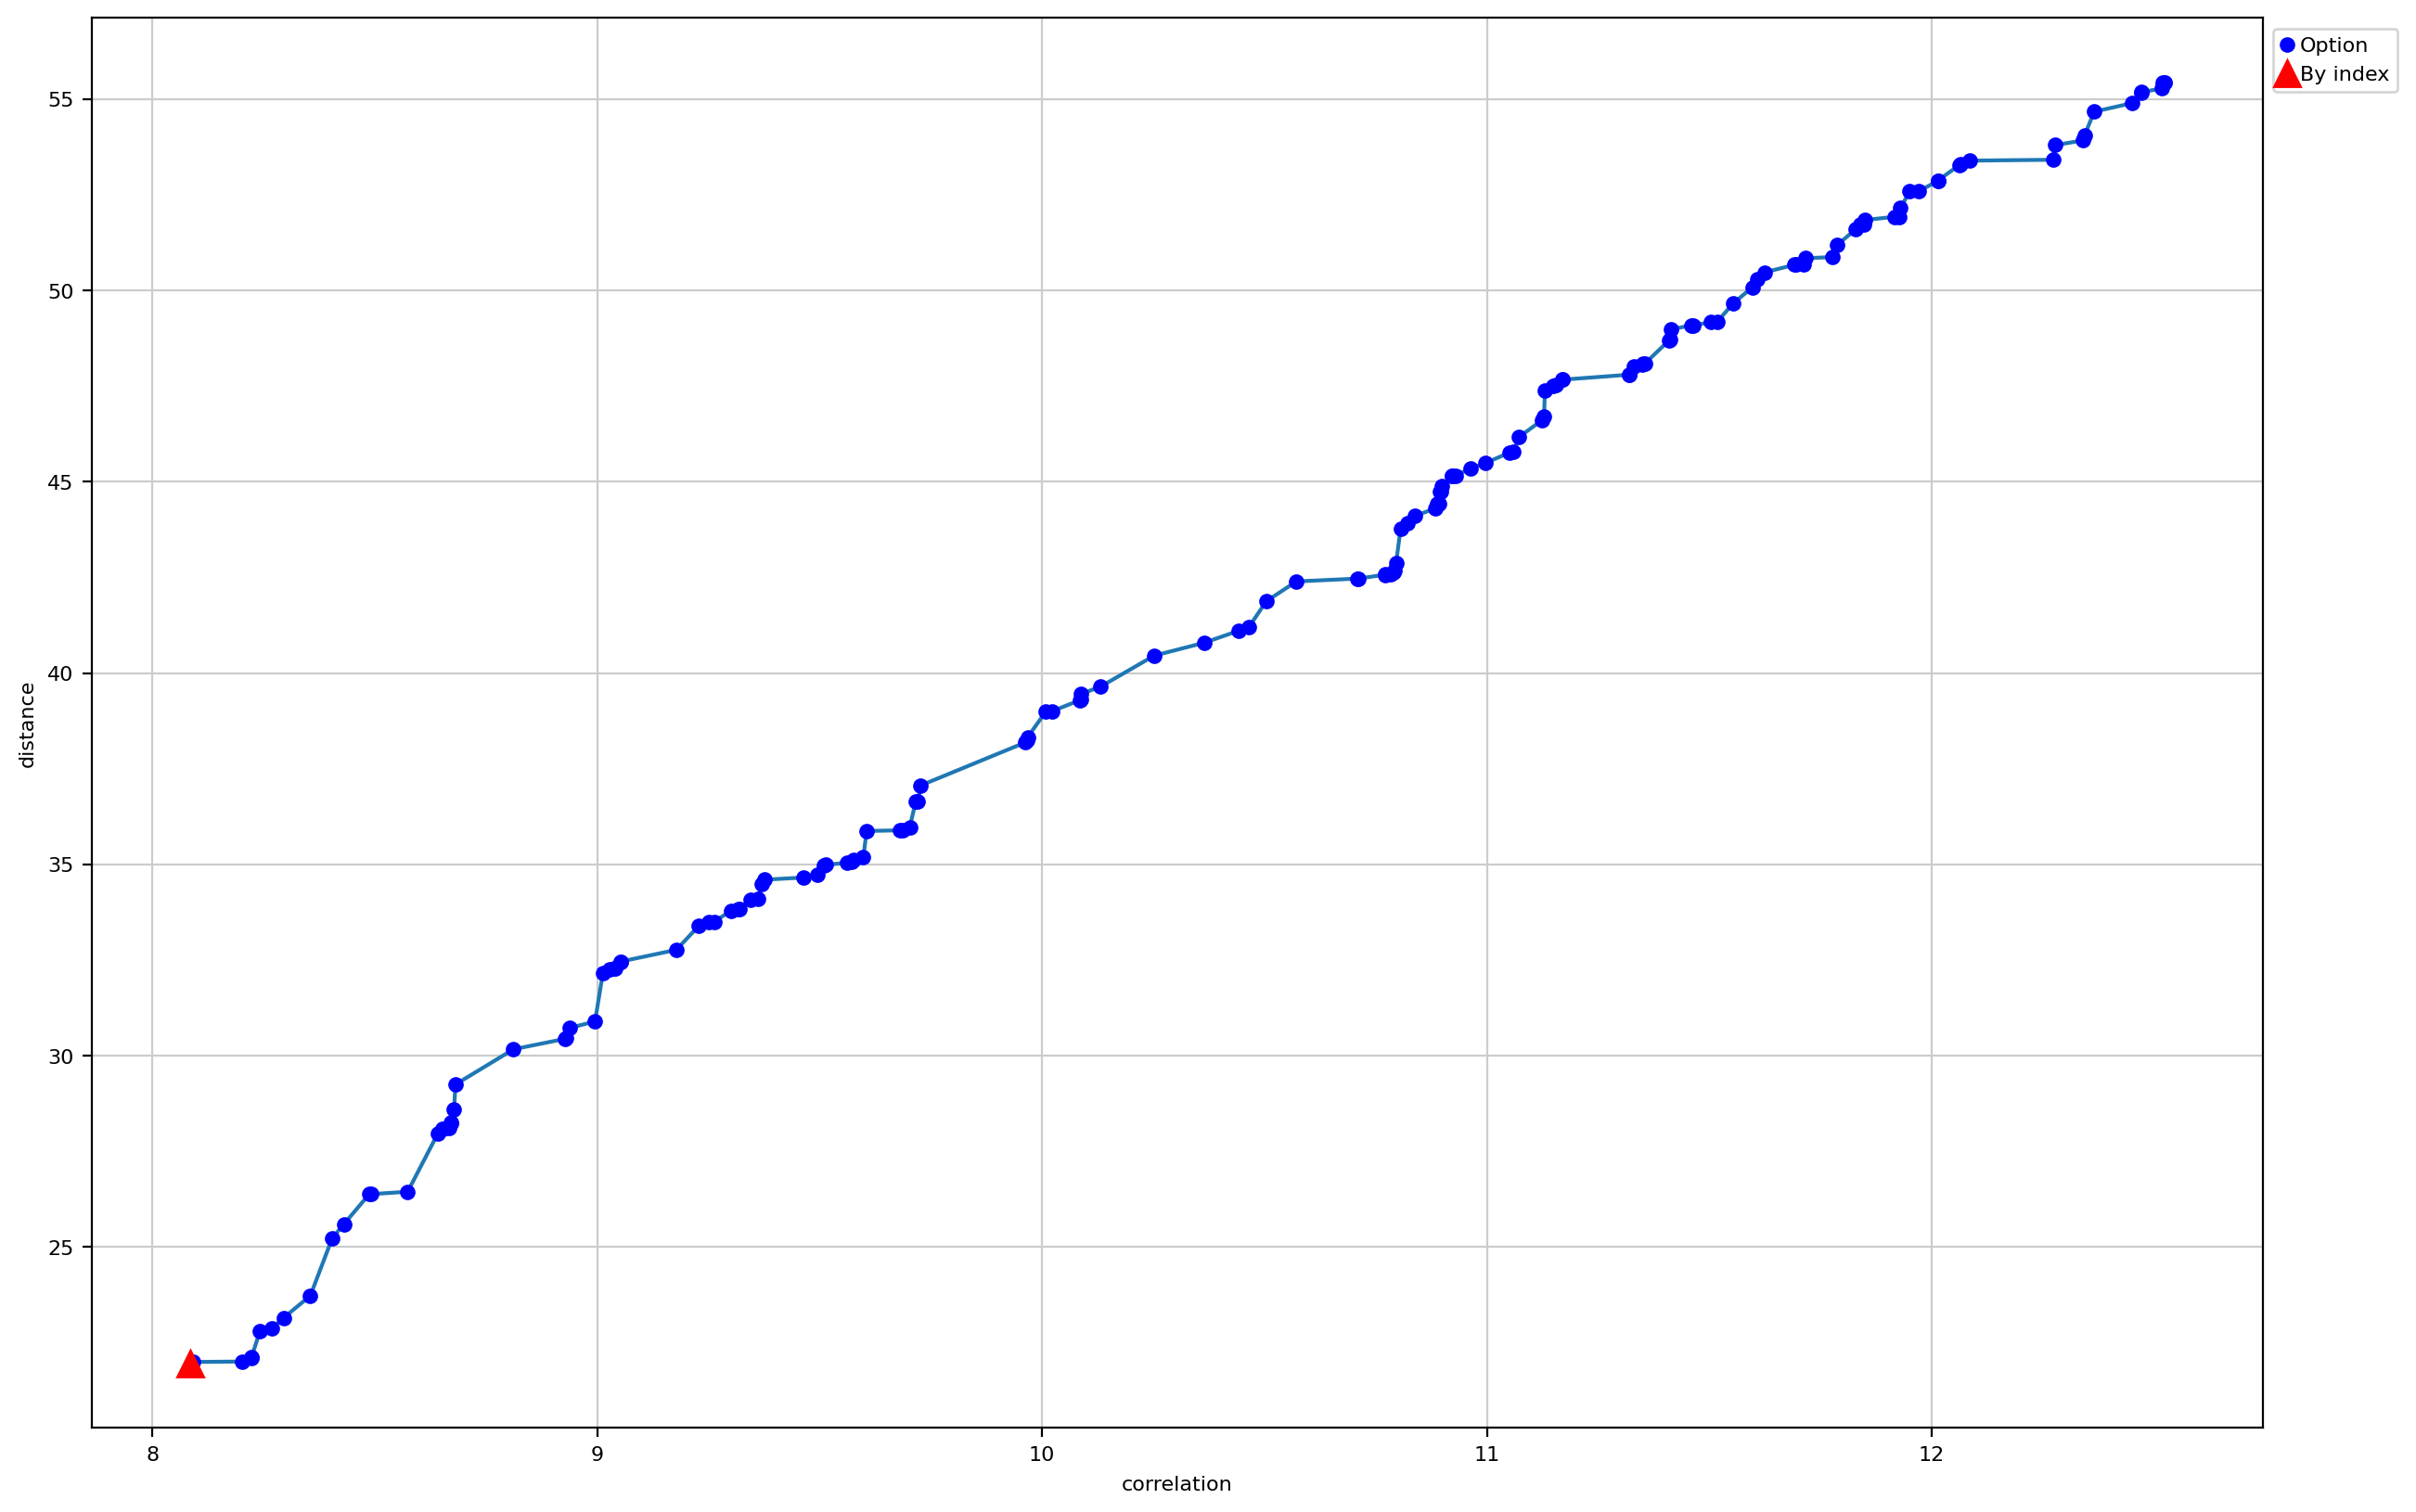

In [37]:
ag.plot(index=0)

In [38]:
index = ag.select(index=0)

In [39]:
from numpy import linalg as LA
def condition(df):
    return LA.cond(df.T, p=2)

In [47]:
index=0
c = []
while True:
    centroids_sc_pareto = centroids_sc_hv[ag.select(index=index)]
    #print(condition(centroids_sc_pareto))
    c.append(condition(centroids_sc_pareto))
    index = index+1
print(c)

ValueError: Invalid index

In [69]:
def plot_(x,y,ylabel,xlabel,title):
    f = plt.figure(figsize=(4,4))
    ax = f.add_subplot(111)
    ax.scatter(x, y, color = 'black',s=3)
    
    #ax.plot(x,y)
    ax.grid(False)
    
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    ax.tick_params(labelsize=12)

    #ax.set_aspect('equal', 'box')
    #ax.xaxis.set_ticklabels([])
    #ax.yaxis.set_ticklabels([])
    #plt.title(title)
    #ax.text(0.8, 0.1,'p='+str(p), ha='center', va='center', transform=ax.transAxes)
    plt.savefig(title+'.png')
    return

In [70]:
sc.set_figure_params(dpi=100, dpi_save=100, vector_friendly=True)
params = {'legend.fontsize': 8,
          'figure.figsize': (3, 3),
         'axes.labelsize':8,
         'axes.titlesize':8,
         'xtick.labelsize':8,
         'ytick.labelsize':8}
plt.rcParams.update(params)

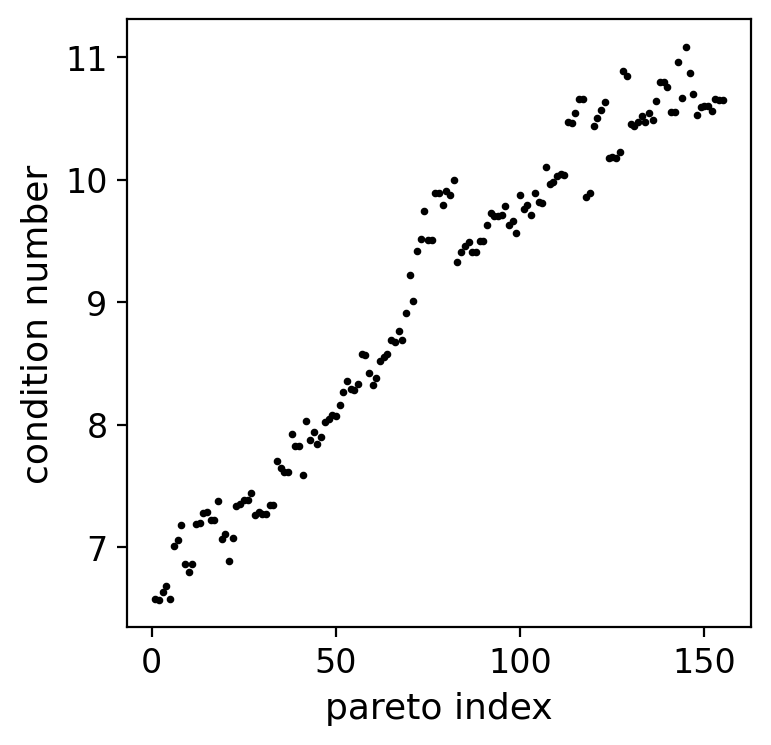

In [71]:
plot_(np.arange(1, len(c)+1, 1),c,"condition number","pareto index",'')

In [ ]:
pd.Data

In [239]:
#filter marker genes in the bulk samples
centroids_sc_pareto = centroids_sc_hv[index]
#data_bulk_proc = data_bulk_raw.loc[centroids_sc_pareto.index,:]

## Regression

In [240]:
coef_nusvr = ag.deconvolve(data_bulk_raw.T, model='nusvr')
coef_nnls = ag.deconvolve(data_bulk_raw.T, model='nnls')

In [241]:
coef_nnls.shape

(100, 6)

In [211]:
clusters

array(['DEC', 'EC', 'H1', 'HFF', 'NPC', 'TB'], dtype='<U3')

In [212]:
proportions_NuSVR = normalize_proportions(pd.DataFrame(data=coef_nusvr,columns=clusters,index=data_bulk_raw.columns), copy = False)
proportions_nnls = normalize_proportions(pd.DataFrame(data=coef_nnls,columns=clusters,index=data_bulk_raw.columns), copy = False)

In [213]:
r_v = 0 
p_v = 0
for c in proportions.columns:
    t = c
    s,i,r,p,e = sci.stats.linregress(proportions[c],proportions_NuSVR[c].astype(float))
    r_v = r_v + r
    p_v = p_v + p
print(datetime.datetime.now()-time0,'\t',r_v/len(proportions.columns),'\t',p_v/len(proportions.columns))
print(p_v/len(proportions.columns))

0:05:36.953678 	 0.7270433272153508 	 0.0006742226563324025
0.0006742226563324025


In [173]:
centroids_sc_mg = centroids_sc_hv.copy()

In [252]:
centroids_sc_mg.shape

(1000, 6)

In [253]:
centroids_sc_hv.shape

(1000, 6)

In [265]:
from sklearn.svm import NuSVR
from sklearn import linear_model

abulks_hv = data_bulk_raw.loc[centroids_sc_hv.index,:]
proportions_NuSVR_hv = pd.DataFrame(index=abulks_hv.columns,columns=centroids_sc_hv.columns)
for s in abulks_hv.columns:
    model = NuSVR(nu=0.5,C=0.5,kernel='linear')
    model.fit(sc_mean.loc[centroids_sc_hv.index,centroids_sc_hv.columns],np.asarray(abulks_hv.loc[:,s]))
    proportions_NuSVR_hv.loc[s] = model.coef_[0]
proportions_NuSVR_hv = normalize_proportions(proportions_NuSVR_hv, copy = True)

In [266]:
r_v = 0
p_v = 0
for c in proportions.columns:
    t = c
    s,i,r,p,e = sci.stats.linregress(proportions[c],proportions_NuSVR_hv[c].astype(float))
    r_v = r_v + r
    p_v = p_v + p
print(r_v/len(proportions.columns),'\t',p_v/len(proportions.columns))
print(p_v/len(proportions.columns))

0.6986939799336179 	 0.16666666666666755
0.16666666666666755


In [256]:
from sklearn.svm import NuSVR
from sklearn import linear_model

abulks_mg = data_bulk_raw.loc[np.intersect1d(list(set(list_mg)),adata_proc.var_names),:]
proportions_NuSVR_mg = pd.DataFrame(index=abulks_mg.columns,columns=centroids_sc_hv.columns)
for s in abulks_mg.columns:
    model = NuSVR(nu=0.5,C=0.5,kernel='linear')
    model.fit(sc_mean.loc[np.intersect1d(list(set(list_mg)),adata_proc.var_names),centroids_sc_hv.columns],np.asarray(abulks_mg.loc[:,s]))
    proportions_NuSVR_mg.loc[s] = model.coef_[0]
    
proportions_NuSVR_mg = normalize_proportions(proportions_NuSVR_mg, copy = True)

In [257]:
r_v = 0
p_v = 0
for c in proportions.columns:
    t = c
    s,i,r,p,e = sci.stats.linregress(proportions[c],proportions_NuSVR_mg[c].astype(float))
    r_v = r_v + r
    p_v = p_v + p
print(r_v/len(proportions.columns),'\t',p_v/len(proportions.columns))
print(p_v/len(proportions.columns))

0.5874970704521804 	 0.1666722039369318
0.1666722039369318


In [55]:
(16.6672461821671)/7.647026689838002


2.179572121059275

In [53]:
val = 0
for x in corr.columns:
    for y in corr.index:
        val = val + corr.loc[x,y]
print(val/2)

7.647026689838002


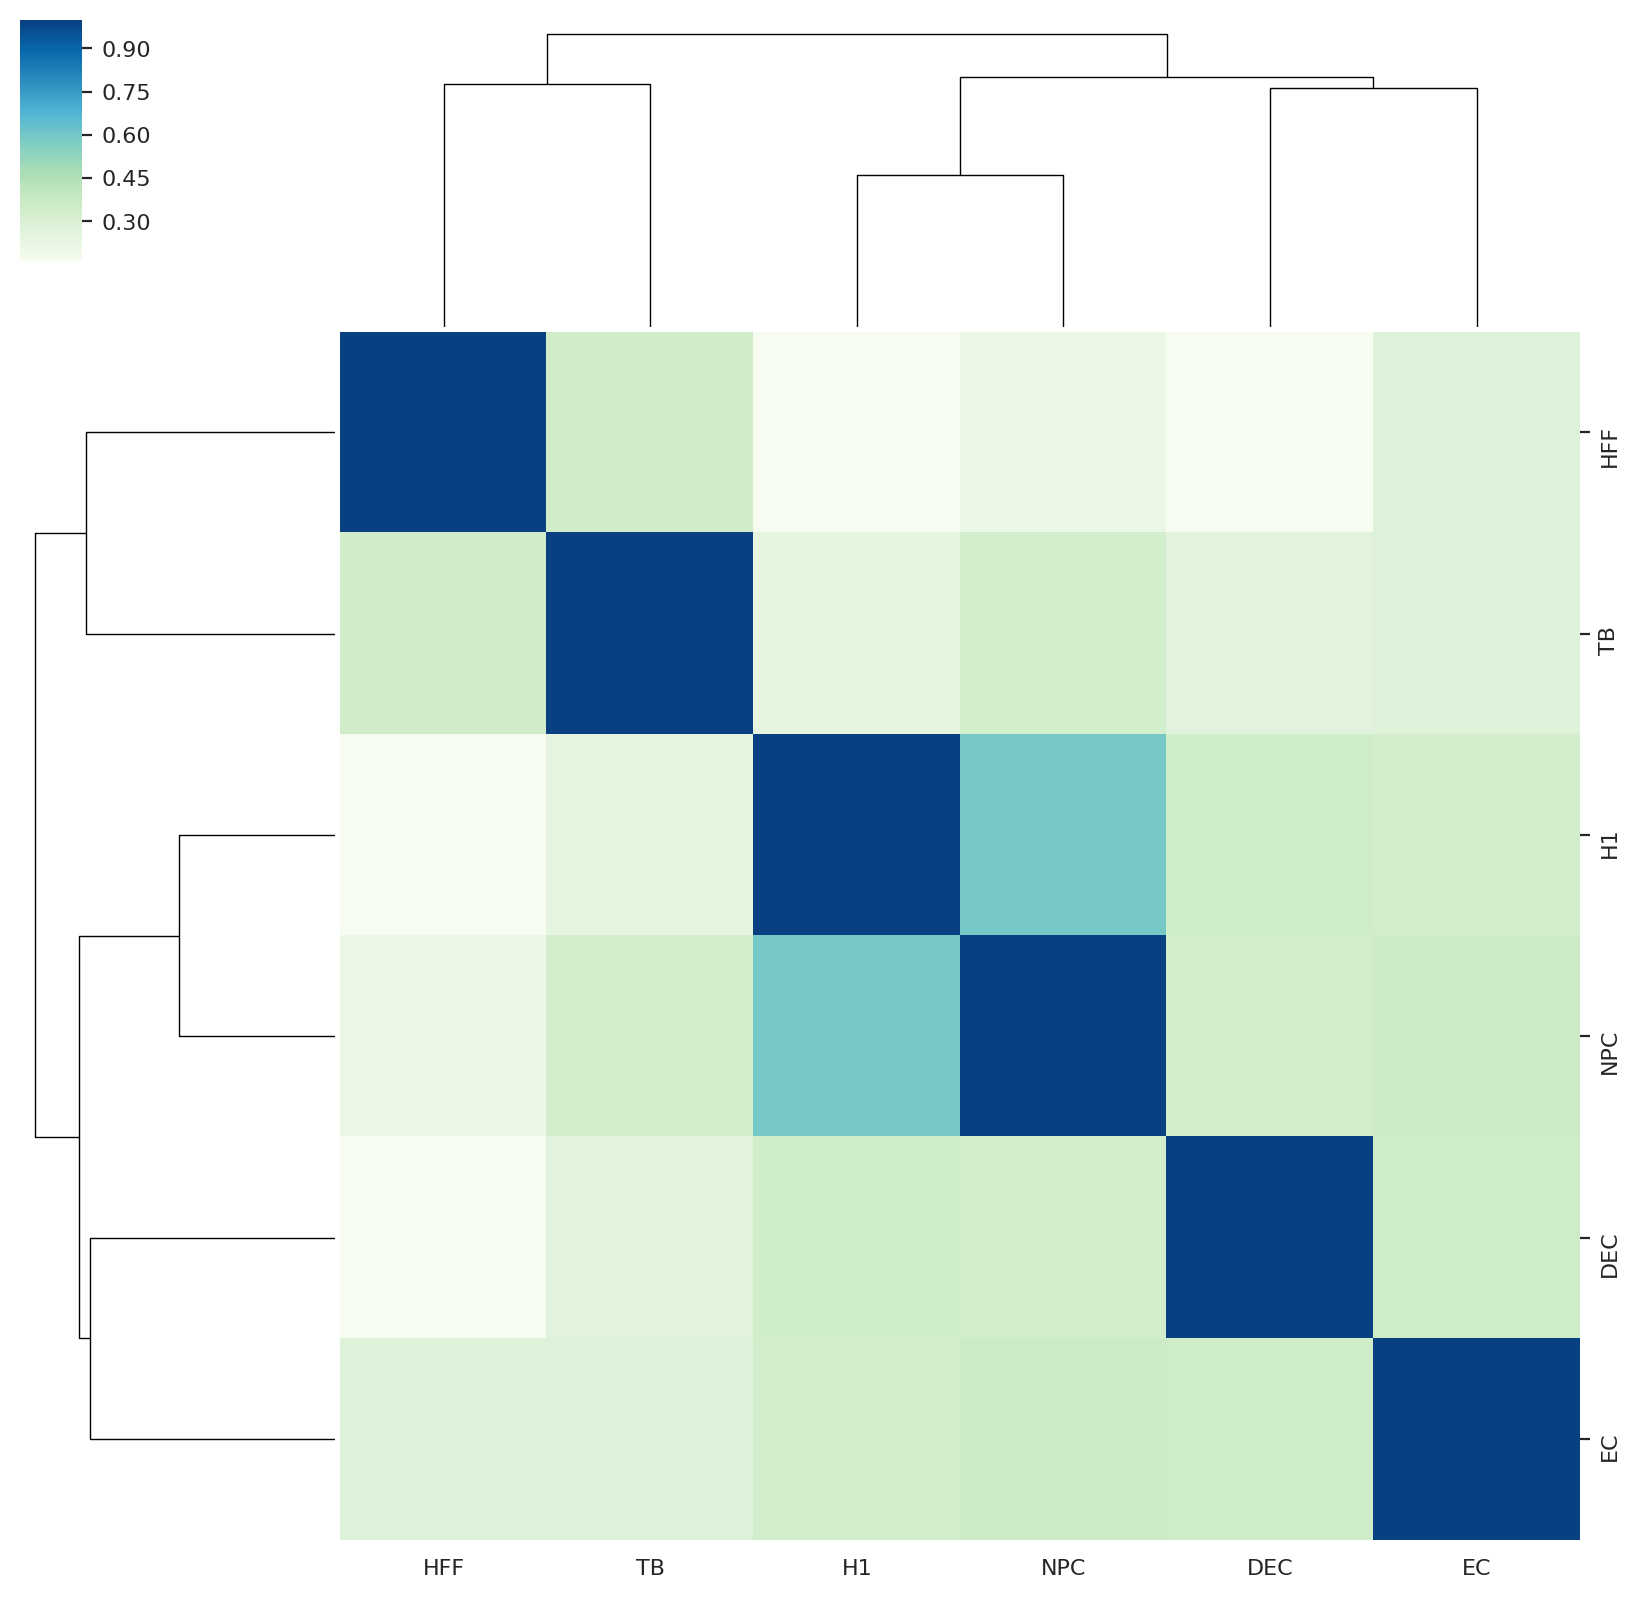

In [52]:
#Correlation matrix
corr = pd.DataFrame(data = np.corrcoef(centroids_sc_hv.T), columns = centroids_sc_hv.columns, index = centroids_sc_hv.columns)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns_plot =sns.clustermap(np.abs(corr),cmap=sns.color_palette("GnBu", 1000), robust=True)

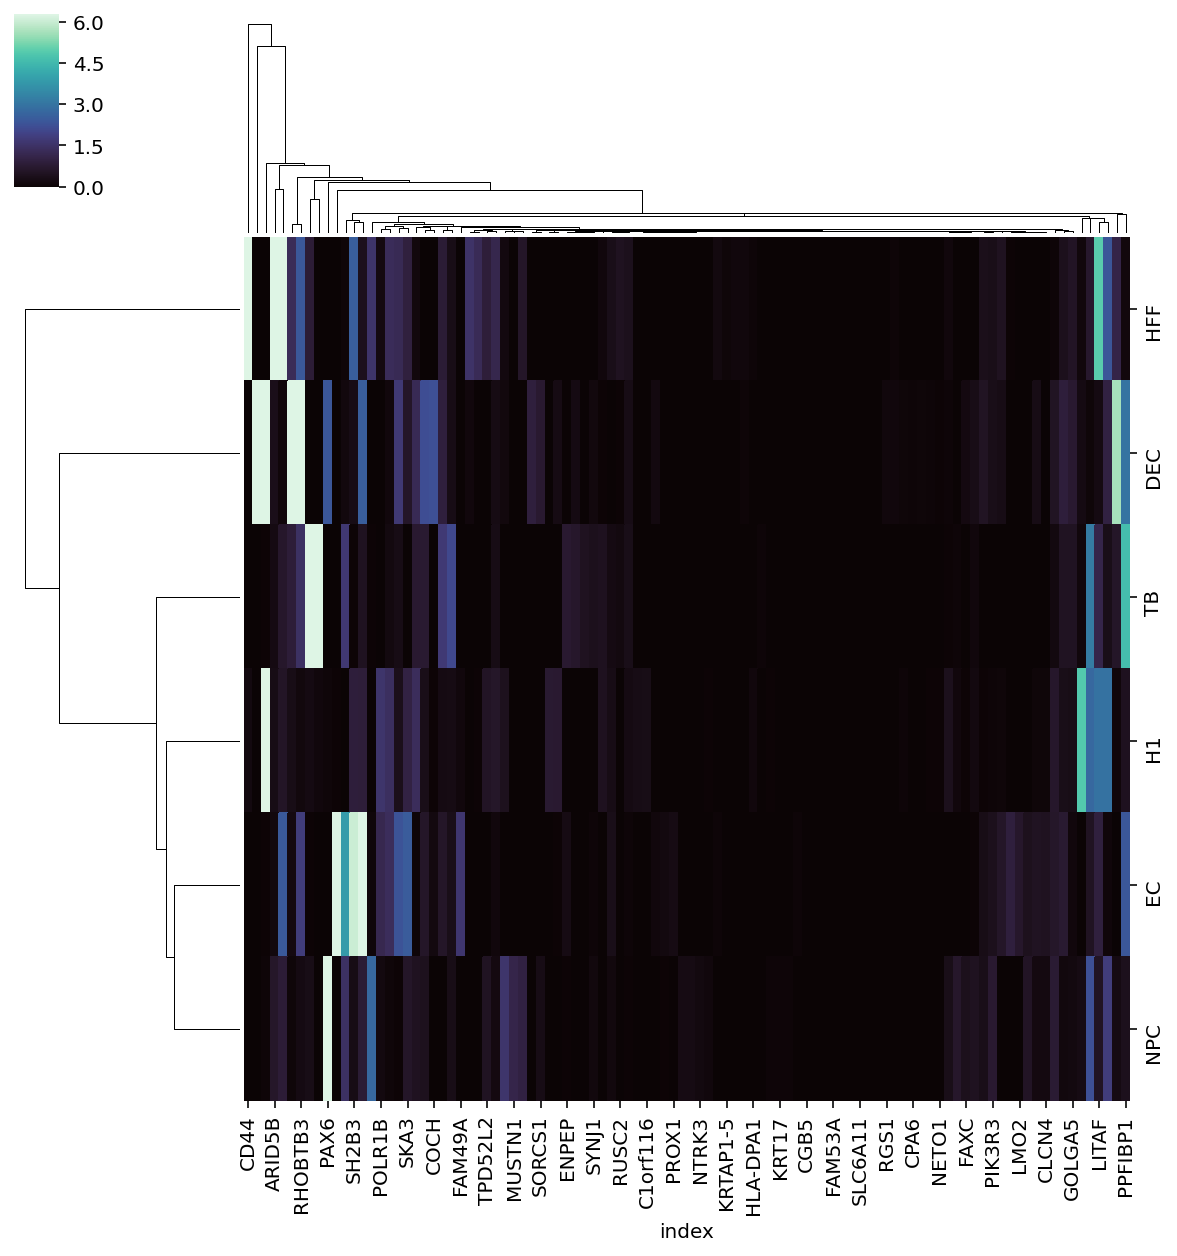

In [113]:
#marker genes
import seaborn as sns
subTypes = pd.DataFrame
subTypes = centroids_sc_pareto.columns
type_pal = sns.husl_palette(centroids_sc_pareto.columns.size, s=0.7)
lut = dict(zip(centroids_sc_pareto.columns.unique(), type_pal))
row_colors = subTypes.map(lut)
sns_plot = sns.clustermap(centroids_sc_pareto.T, cmap="mako", robust=True)

# Validation and plotting the results

In [77]:
def plot_(x,y,title):
    s,i,r,p,e = sci.stats.linregress(x,y)
    f = plt.figure(figsize=(5,5))
    ax = f.add_subplot(111)
    ax.scatter(x, y, color = 'black',s=5)
    
    x = np.linspace(np.min(x), np.max(x), 1000)
    y=x*s+i
    ax.plot(x,y)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    #ax.set_aspect('equal', 'box')
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    plt.title(title)
    ax.text(0.8, 0.1,'p='+str(p), ha='center', va='center', transform=ax.transAxes)
    return

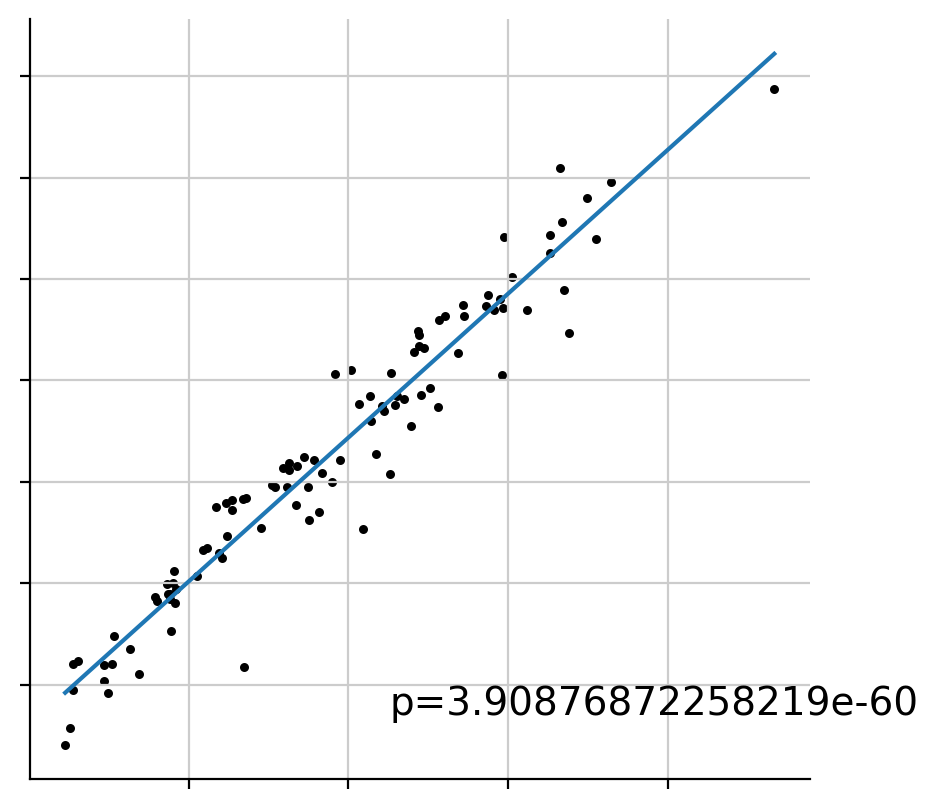

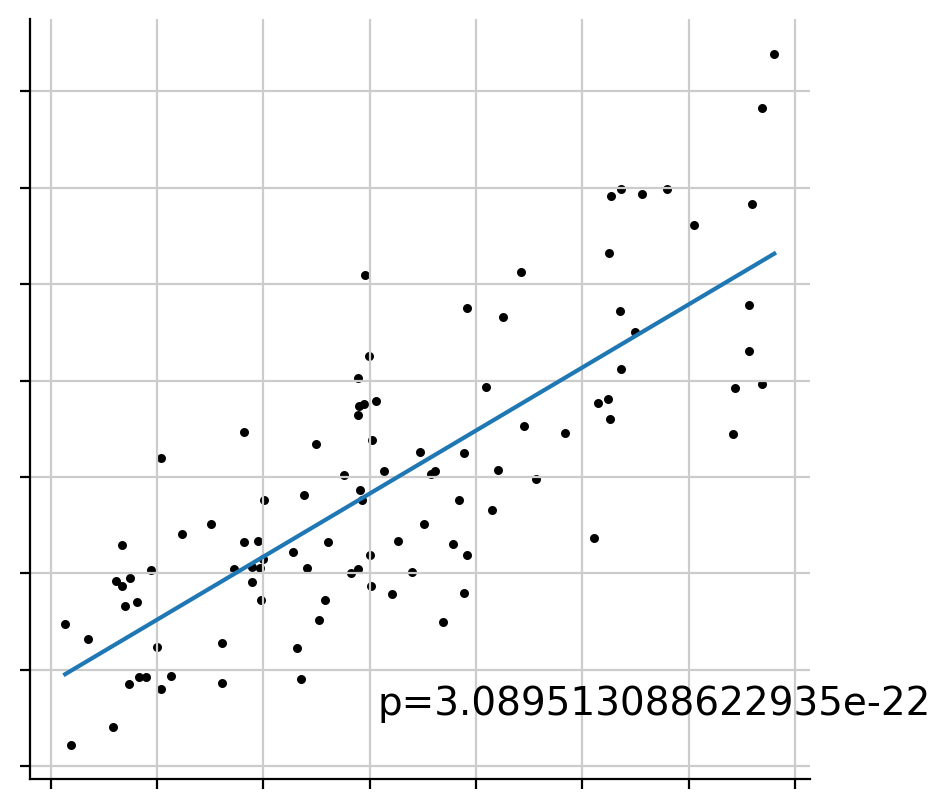

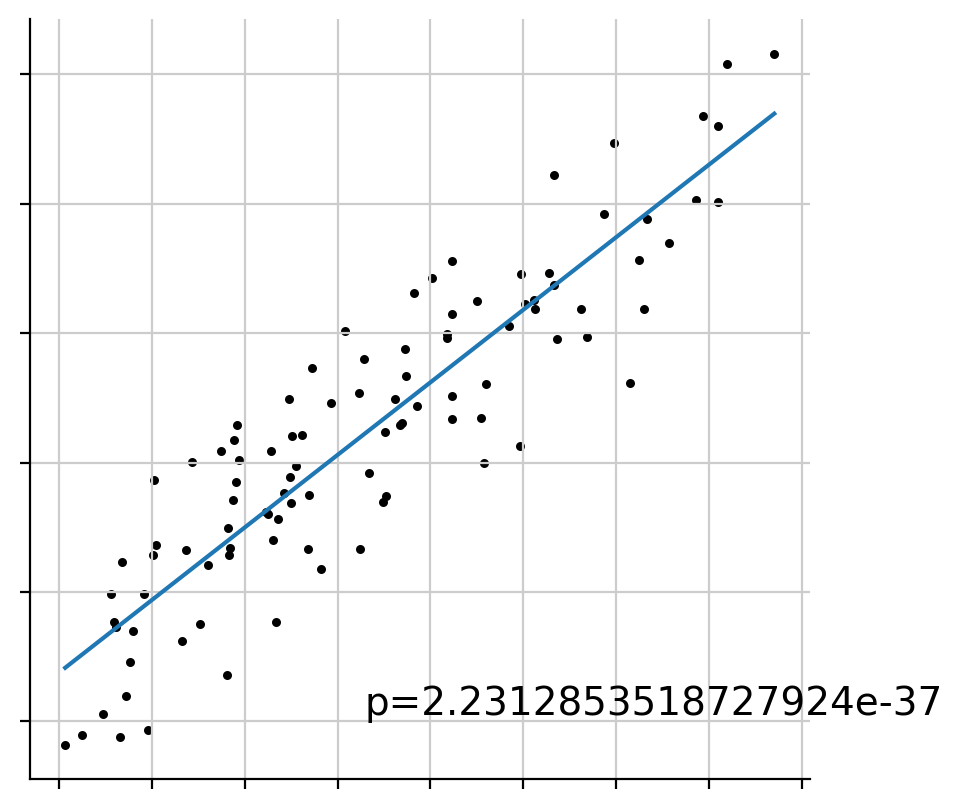

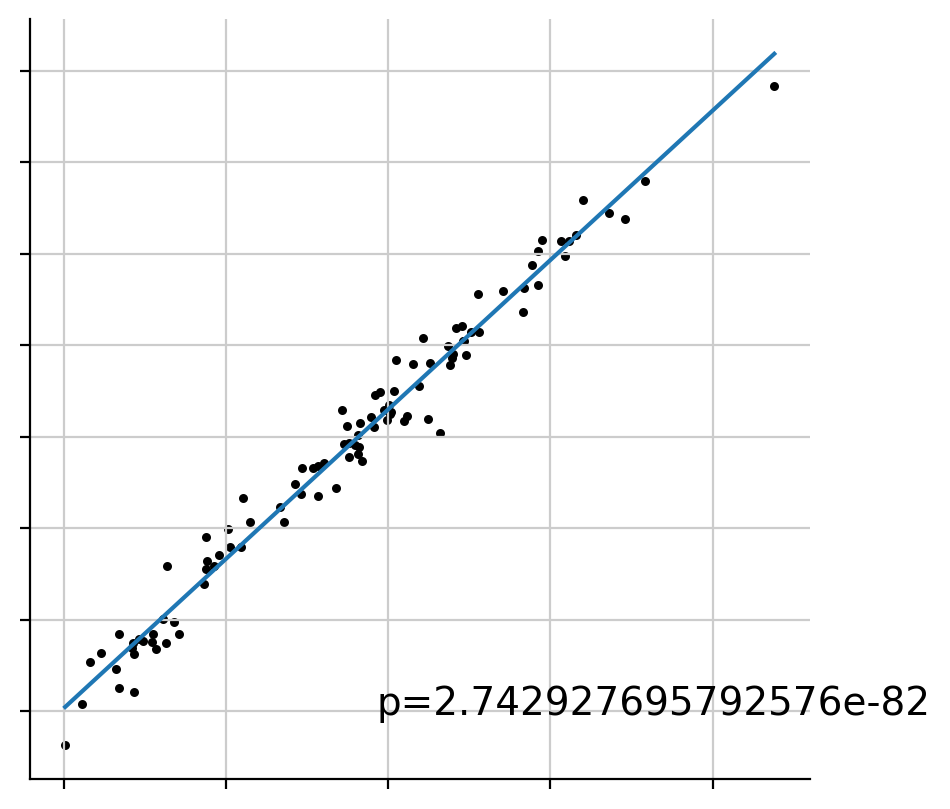

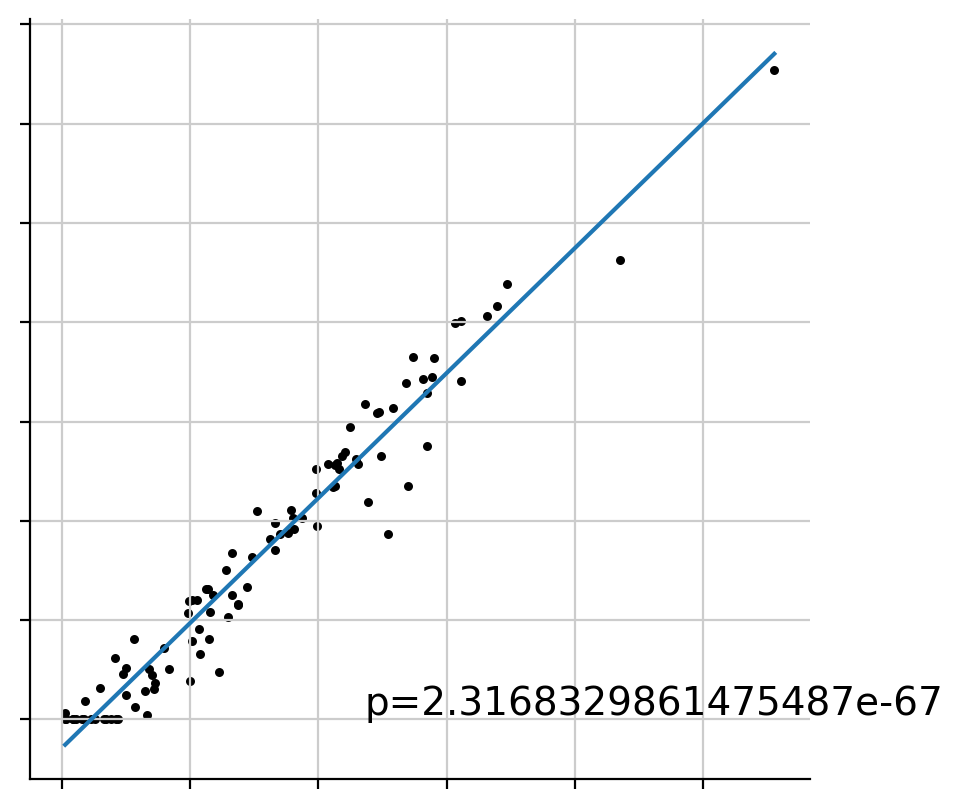

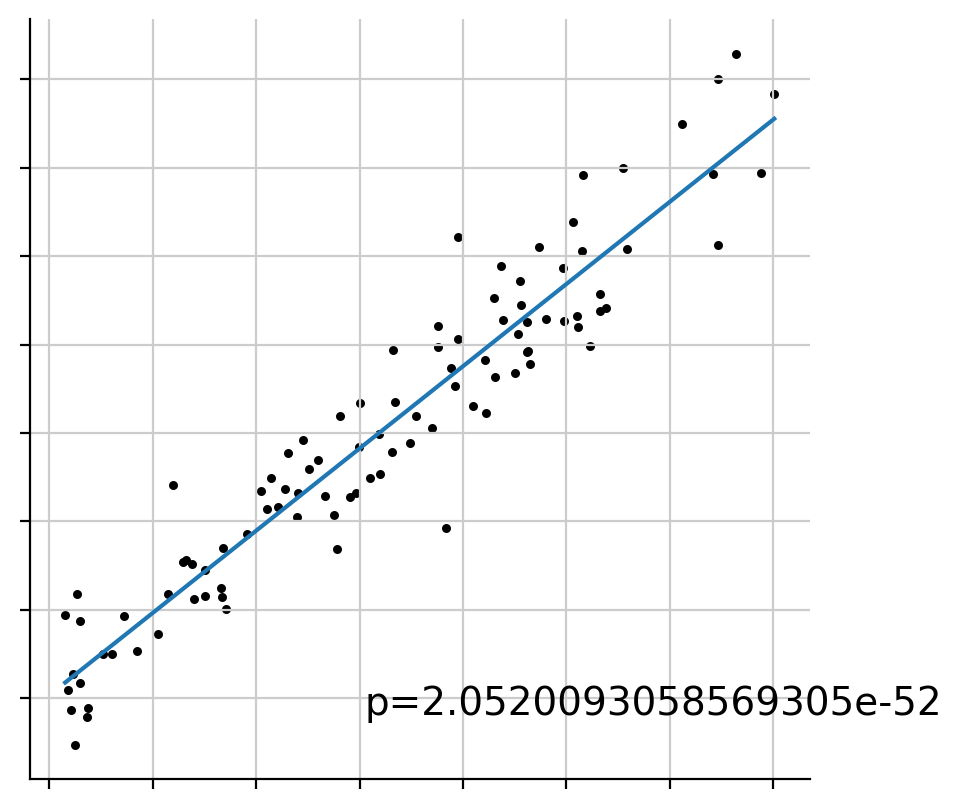

In [78]:
#Comparing real and estimated proportions using NuSVR regression
for c in proportions.columns:
    t = c
    plot_(proportions[c],proportions_NuSVR_hv[c].astype(float),t[5:])

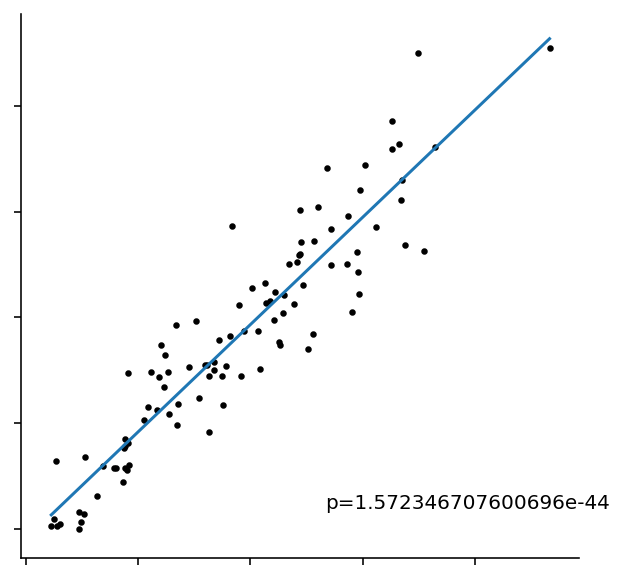

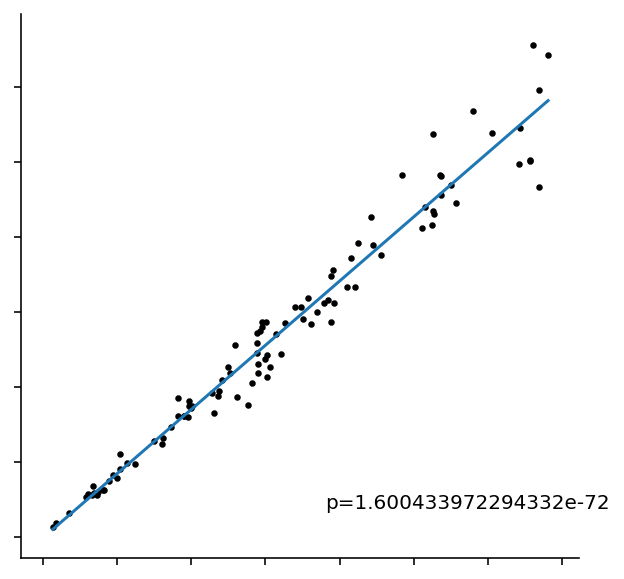

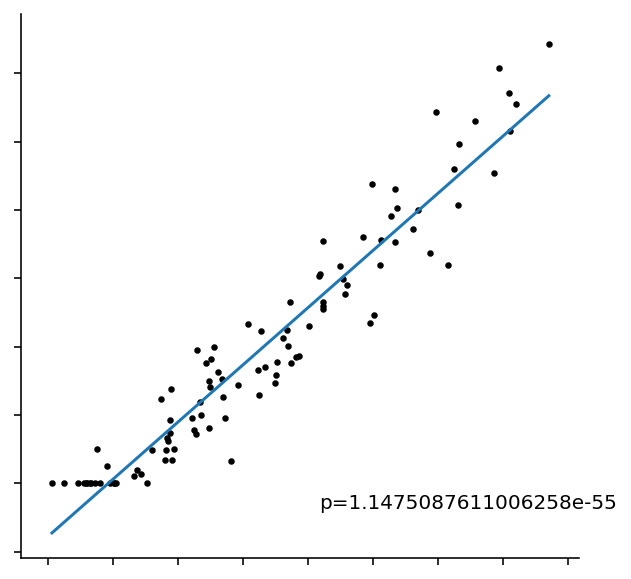

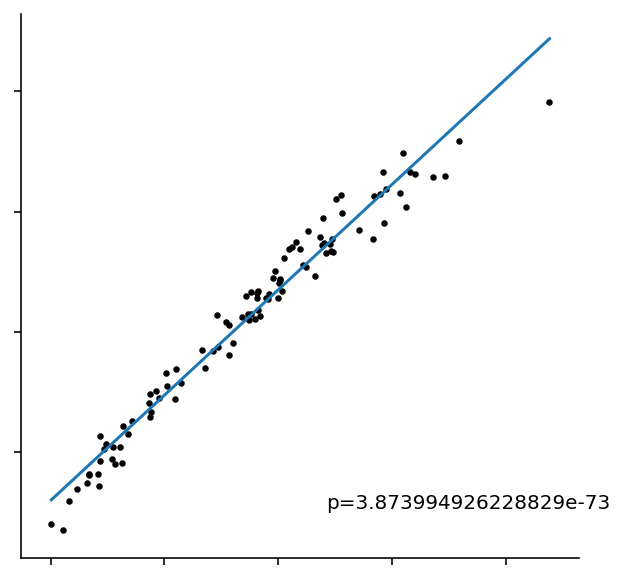

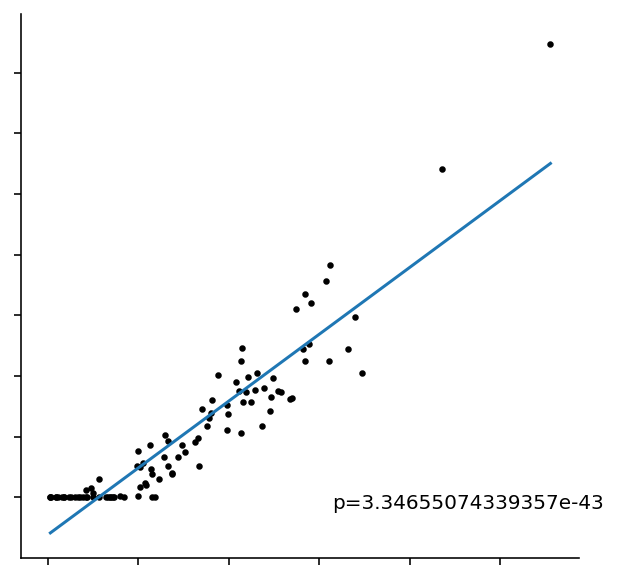

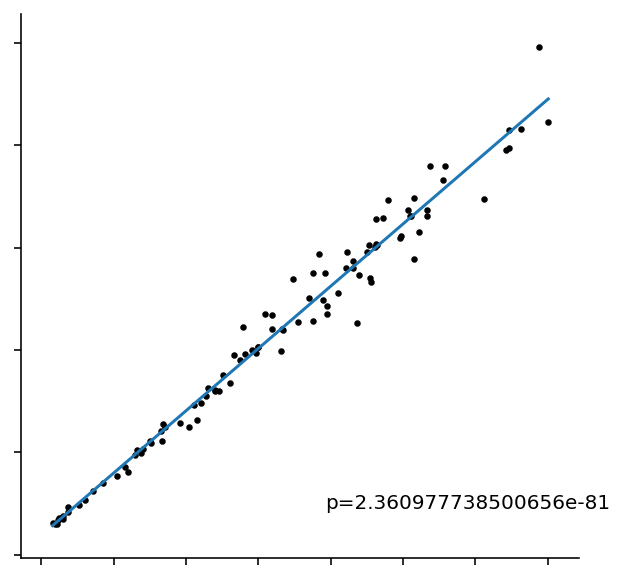

In [22]:
#Comparing real and estimated proportions using nnls
for c in proportions.columns:
    t = c
    plot_(proportions[c],proportions_nnls[c],t[5:])